## DeepMind Paper replication
# The Hydra Effect: Emergent Self-repair in Language Model Computation

# 0. Starter Code. Run this first!
Contains:
- pip installs
- boilerplate imports and jupyter transformerlens initializations
- load pythia-70m code into HookedTransformer

## TransformerLens pip installs

In [1]:
%pip install git+https://github.com/neelnanda-io/TransformerLens.git
%pip install plotly
#!curl -fsSL https://deb.nodesource.com/setup_16.x | sudo -E bash -; sudo apt-get install -y nodejs
%pip install git+https://github.com/neelnanda-io/PySvelte.git
# %pip install sentencepiece # for Llama-2-7b-hf only
%pip install accelerate
%pip install -U kaleido
%pip install nbformat
%pip install seaborn
%pip install fancy_einsum

  Cloning https://github.com/neelnanda-io/TransformerLens.git to /tmp/pip-req-build-uv4okz8t
  Running command git clone -q https://github.com/neelnanda-io/TransformerLens.git /tmp/pip-req-build-uv4okz8t
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 739 kB 6.2 MB/s eta 0:00:01
     |████████████████████████████████| 42 kB 3.1 MB/s  eta 0:00:01
     |████████████████████████████████| 78 kB 18.9 MB/s eta 0:00:01
     |████████████████████████████████| 2.1 MB 39.2 MB/s eta 0:00:01     |████▍                           | 286 kB 39.2 MB/s eta 0:00:01
     |████████████████████████████████| 17.3 MB 34.6 MB/s eta 0:00:01
     |████████████████████████████████| 619.9 MB 66 kB/s /s eta 0:00:01
     |████████████████████████████████| 519 kB 50.6 MB/s eta 0:00:01
     |████████████████████████████████| 12.4 MB 56.1 MB/s eta 0:00:01
     |████████████████████████████████| 239 kB 6

## Imports & visualizations

In [2]:
from IPython import get_ipython
ipython = get_ipython()
# Code to automatically update the TransformerLens code as its edited without restarting the kernel
ipython.magic("load_ext autoreload")
ipython.magic("autoreload 2")
import plotly.io as pio
pio.renderers.default = "png"

/tmp/ipykernel_1236/1711910979.py:4: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  ipython.magic("load_ext autoreload")
/tmp/ipykernel_1236/1711910979.py:5: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  ipython.magic("autoreload 2")


In [3]:
# Import stuff
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import einops
from fancy_einsum import einsum
import tqdm.notebook as tqdm
import random
from pathlib import Path
import plotly.express as px
from torch.utils.data import DataLoader

from jaxtyping import Float, Int
from typing import List, Union, Optional
from functools import partial
import copy

import itertools
from transformers import AutoModelForCausalLM, AutoConfig, AutoTokenizer
import dataclasses
import datasets
from IPython.display import HTML
import pandas as pd

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning:

urllib3 (2.0.5) or chardet (3.0.4) doesn't match a supported version!

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



In [4]:
import pysvelte

import transformer_lens
import transformer_lens.utils as utils
from transformer_lens.hook_points import (
    HookedRootModule,
    HookPoint,
)  # Hooking utilities
from transformer_lens import HookedTransformer, HookedTransformerConfig, FactoredMatrix, ActivationCache

In [5]:
torch.set_grad_enabled(False)

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Load Pythia Model

Probably should add an option to select various models here?

Or we can do one notebook for each pythia model, then have a separate "all-in-one" notebook with a menu to select the pythia model version here.

We can modify that notebook to have clues for which heads and parameters are the right answer (not shown by default) for interpretability conclusions on each model.

For now, just have the one model. For this notebook, it's pythia-70m.

In [7]:
# model loading
model = HookedTransformer.from_pretrained(
    "pythia-12b",
    center_unembed=True,
    center_writing_weights=True,
    fold_ln=True,
)

Loading checkpoint shards: 100%|██████████| 3/3 [00:17<00:00,  5.79s/it]
Using pad_token, but it is not set yet.


Loaded pretrained model pythia-12b into HookedTransformer


# 1. Introduction
TODO:
- include a guide for all further codeblocks to come

## Abstract

We investigate the internal structure of language model computations using causal analysis and demon-
strate two motifs: (1) a form of adaptive computation where ablations of one attention layer of a language
model cause another layer to compensate (which we term the Hydra effect) and (2) a counterbalancing
function of late MLP layers that act to downregulate the maximum-likelihood token. Our ablation studies
demonstrate that language model layers are typically relatively loosely coupled (ablations to one layer
only affect a small number of downstream layers). Surprisingly, these effects occur even in language
models trained without any form of dropout. We analyse these effects in the context of factual recall
and consider their implications for circuit-level attribution in language models.
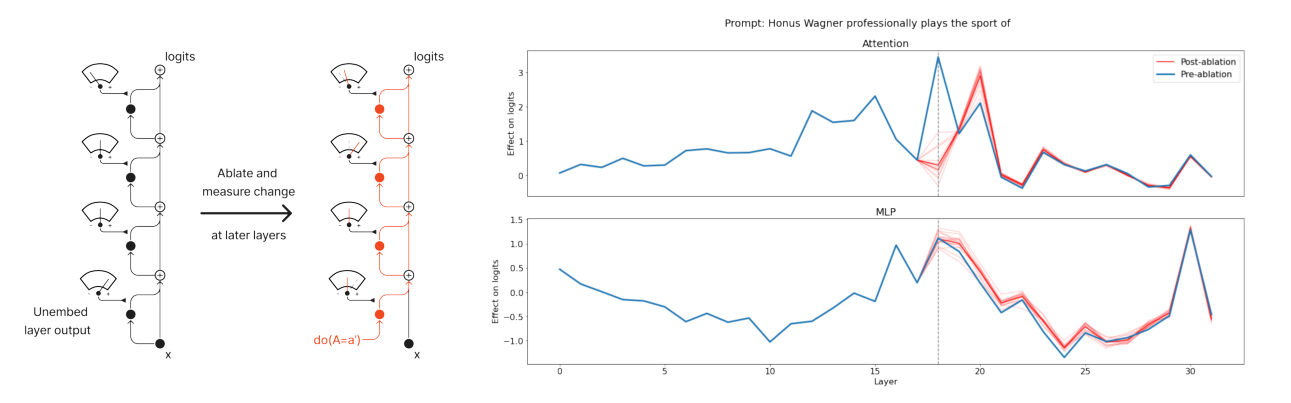
Figure 1 | Diagram of our protocol for investigating network self-repair and illustrative results. The
blue line indicates the effect on output logits for each layer for the maximum-likelihood continuation
of the prompt shown in the title. Faint red lines show direct effects following ablation of at a single
layer indicated by dashed vertical line (attention layer 18 in this case) using patches from different
prompts and the solid red line indicates the mean across patches. See Section 2 for details.

## 1.0 Actual introduction text

Ablation studies are a vital tool in our attempts to understand the internal computations of neural
networks: by ablating components of a trained network at inference time and studying the down-
stream effects of these ablations we hope to be able to map the network’s computational structure and
attribute responsibility among different components. In order to interpret the results of interventions
on neural networks we need to understand how network computations respond to the types of
interventions we typically perform. A natural expectation is that ablating important components will
substantially degrade model performance (Morcos et al., 2018) and may cause cascading failures that
break the network. We demonstrate that the situation in large language models (LLMs) is substantially
more complex: LLMs exhibit not just redundancy but actively self-repairing computations. When one
layer of attention heads is ablated, another later layer appears to take over its function. We call this the Hydra effect: when one set of heads is cut off, other heads grow in importance1. We present these
results in Section 2.

The Hydra effect (referred to in (Wang et al., 2022) as backup behaviour) complicates our un-
derstanding of what it means for a network component to be important because two natural-seeming
measures of importance (unembedding and ablation-based measures) become much less correlated
than we would naïvely expect. These impact measurements correspond to the direct and total ef-
fect, which we introduce in a short, self-contained primer on causal inference in neural networks
in Section 3 before performing a more comprehensive quantitative analysis of the Hydra effect in
Section 4. Finally we discuss related work in Section 5 and close by hypothesising possible causes for
our findings and discuss their implications for future causal analyses of language model computations
in Section 6.

## 1.1 Guide for our notebook implementation


**We implement:**
- The equivalent of all interpretability tools and results for the Pythia model suite
- (2.2) Loading the CounterFact dataset
- (2.3) Logit lens (early LN -> W_U)
- (2.3.1) delta_unembed impact measurement
- (Appendix A) Averaged resampling ablation
- (Throughout) All plots from the paper
- (3.2, 3.3, 3.4) direct, indirect, and total effects
- (4.1) total compensatory effect following an ablation

# 2. Self-repair and the Hydra 
**TODO:**
- copy paste all text as is for the whole paper (done!)
- Format that text into blocks that make sense. remove badly formatted stuff, actually write it up nicely (done!)
- fix up the KaTeX for this section (100% done!)
- setup transformerlens starter code (done!)
- arrange codeblocks where work needs to be filled in (done!)
- fill in codeblocks (almost done)
- include graphics where there are figures and plots from the OG paper
- add figure description blocks for them

NOTE:
- Pythia uses LayerNorm, not RMSNorm. Those sections of the paper are irrelevant for our replication

## 2.1 The Transformer architecture for autoregressive language modelling

In [9]:
# might want to implement, for completeness sake, implementation of these
# even if it isn't used directly in the rest of the code

In [8]:
# print model config in this section
model.cfg

HookedTransformerConfig:
{'act_fn': 'gelu',
 'add_special_tokens': True,
 'attention_dir': 'causal',
 'attn_only': False,
 'attn_types': None,
 'checkpoint_index': None,
 'checkpoint_label_type': None,
 'checkpoint_value': None,
 'd_head': 128,
 'd_mlp': 20480,
 'd_model': 5120,
 'd_vocab': 50688,
 'd_vocab_out': 50688,
 'default_prepend_bos': True,
 'device': device(type='cuda'),
 'dtype': torch.float32,
 'eps': 1e-05,
 'final_rms': False,
 'from_checkpoint': False,
 'gated_mlp': False,
 'init_mode': 'gpt2',
 'init_weights': False,
 'initializer_range': 0.011180339887498949,
 'model_name': 'pythia-12b',
 'n_ctx': 2048,
 'n_devices': 1,
 'n_heads': 40,
 'n_layers': 36,
 'n_params': 11324620800,
 'normalization_type': 'LNPre',
 'original_architecture': 'GPTNeoXForCausalLM',
 'parallel_attn_mlp': True,
 'positional_embedding_type': 'rotary',
 'rotary_dim': 32,
 'scale_attn_by_inverse_layer_idx': False,
 'seed': None,
 'tokenizer_name': 'EleutherAI/pythia-12b',
 'use_attn_result': False,


We want to analyse the computational structure of large autoregressive language models with an
decoder-only Transformer architecture. In this work we use a 7 billion parameter model from the
Chinchilla family (meaning that the architecture and training setup is identical to that proposed
in (Hoffmann et al., 2022) but the model is approximately 7 billion parameters and the training
dataset size is scaled down appropriately). An autoregressive language model maps a sequence of
input tokens $x_{\leq t} = (x_1, . . . , x_t)$ of length $t$ to a probability distribution over the next token $x_{t+1}$ using a
function $f_\theta$

\begin{align}
p(x_{t+1} \mid x \leq t) = f_\theta(x \leq t) \tag{1} \\
= \text{softmax}(\pi_t(x_{\leq t})), \tag{2}
\end{align}
where the pre-softmax values $\pi$ are called the logits. The function $f_\theta$ is a standard Transformer architecture comprised of $L$ layers

\begin{align}
\pi_t = && \text{RMSNorm}(z_t^L)W_U \tag{3}\\
z_t^l = && z_t^{l-1} + a_t^l + m_t^l \tag{4}\\
a_t^l = && \text{Attn}(z_{\leq t}^{l-1}) \tag{5}\\
m_t^l = && \text{MLP}(z_t^{l-1}) \tag{6}
\end{align}
where $\text{RMSNorm}(·)$ is an RMSNorm normalisation layer, $W_U$ an unembedding matrix Attn(·) an attention layer (Bahdanau et al., 2014; Vaswani et al., 2017) and MLP(·) a two-layer perceptron. The
dependence of these functions on the model parameters $\theta$ is left implicit. In common with much of the
literature on mechanistic interpretability (e.g. Elhage et al. (2021)) we refer to the series of residual
activations $z_i^l, i=1, \dots, t$ as the residual stream. For more details on the Transformer architecture
in language modelling and the specific details of Chinchilla language models see (Hoffmann et al.,
2022; Phuong and Hutter, 2022). As an additional notational shorthand we will typically denote
the dependence of network activations on inputs by skipping the repeated function composition and
simply writing $z_l^t(x_{\leq t})$ or $a_t^l(x_{\leq t}, m_t^l(x_{\leq t}))$ to denote the activations at layer $l$, position $t$ due to input string $x \leq t$ rather than writing the full recursive function composition implied by Equations 3-6.

## 2.2 Using the Counterfact dataset to elicit factual recall

### Load dataset, initial playing around

In [9]:
from datasets import load_dataset

dataset = load_dataset("NeelNanda/counterfact-tracing")

In [10]:
dataset
# for counterfact dataset here, there's just one split: train
dataset = dataset['train']

In [11]:
dataset

Dataset({
    features: ['relation', 'relation_prefix', 'relation_suffix', 'prompt', 'relation_id', 'target_false_id', 'target_true_id', 'target_true', 'target_false', 'subject'],
    num_rows: 21919
})

The Counterfact dataset, introduced in (Wang et al., 2022), is a collection of factual statements
originally intended to evaluate the efficacy of model editing. The dataset comprises a series of
prompts formed by combining tuples of subject, relation, and object $(s,r,o^*,o^c)$ where $s$ is the subject (e.g. Honus Wagner), $r$ the relation (e.g. “professionally plays the sport of”), $o^*$ the true object (e.g. baseball), and $o^c$ some counterfactual claim that makes sense in context. We are interested in the
way that language models store and relate factual knowledge so we only use the concatentation of $s$
and $r$ to form our prompts. This produces prompts whose completion requires factual knowledge that
Chinchilla 7B can completely answer correctly.

In [12]:
# list 10 rows of the dataset
dataset.select(range(10))
'''Dataset({
    features: ['relation', 'relation_prefix', 'relation_suffix', 'prompt', 'relation_id', 'target_false_id', 'target_true_id', 'target_true', 'target_false', 'subject'],
    num_rows: 10
})'''
# actually show the table
dataset.select(range(10)).to_pandas()

,relation,relation_prefix,relation_suffix,prompt,relation_id,target_false_id,target_true_id,target_true,target_false,subject
0,The mother tongue of {} is,The mother tongue of,is,The mother tongue of Danielle Darrieux is,P103,Q1860,Q150,French,English,Danielle Darrieux
1,The official religion of {} is,The official religion of,is,The official religion of Edwin of Northumbria is,P140,Q432,Q5043,Christianity,Islam,Edwin of Northumbria
2,"{}, the",,"{}, the","Toko Yasuda, the",P1303,Q5994,Q6607,guitar,piano,Toko Yasuda
3,"{}, which is located in",,"{}, which is located in","Autonomous University of Madrid, which is loca...",P17,Q34,Q29,Spain,Sweden,Autonomous University of Madrid
4,What is the twin city of {}? It is,What is the twin city of,? It is,What is the twin city of Lyon? It is,P190,Q1461,Q3820,Beirut,Manila,Lyon
5,The mother tongue of {} is,The mother tongue of,is,The mother tongue of Thomas Joannes Stieltjes is,P103,Q1860,Q7411,Dutch,English,Thomas Joannes Stieltjes
6,"{}, that was created in",,"{}, that was created in","Anaal Nathrakh, that was created in",P740,Q1345,Q2256,Birmingham,Philadelphia,Anaal Nathrakh
7,{} was created by,,{} was created by,Apple A5 was created by,P178,Q95,Q312,Apple,Google,Apple A5
8,What is the twin city of {}? It is,What is the twin city of,? It is,What is the twin city of Wellington? It is,P190,Q42448,Q3130,Sydney,Sheffield,Wellington
9,"{}, created in",,"{}, created in","Shree Pundalik, created in",P495,Q34,Q668,India,Sweden,Shree Pundalik


In [13]:
# store all unique relation prefixes in a list
relation_prefixes = dataset.unique("relation_prefix")
# print them
relation_prefixes

# want to sample from non '' refixes
# create grouped = groupby object. filter there via grouped.

['The mother tongue of',
 'The official religion of',
 '',
 'What is the twin city of',
 'The original language of',
 'The headquarter of',
 'What does',
 'The native language of',
 'The profession of',
 'The language used by',
 'In',
 'The twin city of',
 'The language of',
 'Which position does',
 'The expertise of',
 'The law in',
 'The headquarters of',
 'The occupation of',
 'The domain of activity of',
 'The official language of',
 'The location of',
 'Where is',
 'What sport does',
 'The genre played by',
 'The capital of',
 'The domain of work of',
 'The capital city of',
 'The music label that is representing',
 'The music label representing']

In [39]:
# categorize the original dataset by relation_prefix using pandas groupby
grouped = dataset.to_pandas().groupby("relation_prefix") # into pandas dataframe
# Let's fetch the entries in one of the groups
grouped.get_group('The capital city of') # pandas dataframe consisting of just the rows of interest. so this is a pre-equiv class
# write the size of each group and put this in a dictionary along with the name of the group
group_sizes = {name: len(group) for name, group in grouped}
# sort this by length of group in descending order
group_sizes = dict(sorted(group_sizes.items(), key=lambda x: x[1], reverse=True))
group_sizes
#print(grouped.get_group("The domain of activity of")["prompt"])

{'': 17575,
 'In': 531,
 'The language of': 493,
 'The original language of': 371,
 'The language used by': 225,
 'The headquarter of': 224,
 'What is the twin city of': 207,
 'The twin city of': 204,
 'The law in': 186,
 'The mother tongue of': 174,
 'The official language of': 174,
 'Which position does': 169,
 'The native language of': 153,
 'What does': 147,
 'The genre played by': 136,
 'The location of': 132,
 'The occupation of': 128,
 'The profession of': 121,
 'The headquarters of': 112,
 'Where is': 102,
 'The official religion of': 101,
 'What sport does': 54,
 'The domain of activity of': 53,
 'The domain of work of': 52,
 'The expertise of': 48,
 'The capital of': 24,
 'The capital city of': 17,
 'The music label that is representing': 4,
 'The music label representing': 2}

In [15]:
# categorize the original dataset by relation_prefix using pandas groupby
grouped_suffix = dataset.to_pandas().groupby("relation_suffix") # into pandas dataframe
# Let's fetch the entries in one of the groups
#grouped.get_group("? It is") # pandas dataframe consisting of just the rows of interest. so this is a pre-equiv class
# write the size of each group and put this in a dictionary along with the name of the group
group_sizes = {name: len(group) for name, group in grouped_suffix}
# sort this by length of group in descending order
group_sizes = dict(sorted(group_sizes.items(), key=lambda x: x[1], reverse=True))
group_sizes
tokenizer = model.tokenizer
# for each key in group_sizes, show the length of its tokenization
#for key in group_sizes:
#    print(key, ", Group size of", group_sizes[key], ", tokenized length is ", len(tokenizer(key)["input_ids"]))
    
# sort this by tokenized length of key in descending order
group_sizes = dict(sorted(group_sizes.items(), key=lambda x: len(tokenizer(x[0])["input_ids"]), reverse=True))
for key in group_sizes:
    print(key, ", Group size of", group_sizes[key], ", tokenized length is ", len(tokenizer(key)["input_ids"]))
#print(grouped.get_group("The domain of activity of")["prompt"])

# print the first key in group_sizes
key1 = list(group_sizes.keys())[1]


{} is a part of the continent of , Group size of 153 , tokenized length is  8
{} is located in the country of , Group size of 171 , tokenized length is  7
{} was created in the country of , Group size of 66 , tokenized length is  7
{}'s area of work is , Group size of 56 , tokenized length is  7
{}'s domain of activity is , Group size of 50 , tokenized length is  7
{}'s domain of work is , Group size of 46 , tokenized length is  7
{} is a twin city of , Group size of 210 , tokenized length is  6
{} plays in the position of , Group size of 191 , tokenized length is  6
{} is located in the continent , Group size of 162 , tokenized length is  6
{}, who has a citizenship from , Group size of 155 , tokenized length is  6
{} belongs to the continent of , Group size of 152 , tokenized length is  6
{} worked in the city of , Group size of 149 , tokenized length is  6
{} is a native speaker of , Group size of 142 , tokenized length is  6
{}, who is a citizen of , Group size of 138 , tokenized l

In [16]:
print(key1, type(key1))
grouped_suffix.get_group(key1)

{} is located in the country of <class 'str'>


,relation,relation_prefix,relation_suffix,prompt,relation_id,target_false_id,target_true_id,target_true,target_false,subject
104,{} is located in the country of,,{} is located in the country of,Hohenlohe-Langenburg is located in the country of,P17,Q38,Q183,Germany,Italy,Hohenlohe-Langenburg
109,{} is located in the country of,,{} is located in the country of,Shablykinsky District is located in the countr...,P17,Q184,Q159,Russia,Belarus,Shablykinsky District
125,{} is located in the country of,,{} is located in the country of,Manila Light Rail Transit System is located in...,P17,Q212,Q928,Philippines,Ukraine,Manila Light Rail Transit System
151,{} is located in the country of,,{} is located in the country of,Ozumba is located in the country of,P17,Q159,Q96,Mexico,Russia,Ozumba
239,{} is located in the country of,,{} is located in the country of,Nizampatnam is located in the country of,P17,Q117,Q668,India,Ghana,Nizampatnam
...,...,...,...,...,...,...,...,...,...,...
21680,{} is located in the country of,,{} is located in the country of,Lake Timiskaming is located in the country of,P17,Q115,Q16,Canada,Ethiopia,Lake Timiskaming
21732,{} is located in the country of,,{} is located in the country of,Bintulu Division is located in the country of,P17,Q1019,Q833,Malaysia,Madagascar,Bintulu Division
21739,{} is located in the country of,,{} is located in the country of,Tatsuno is located in the country of,P17,Q408,Q17,Japan,Australia,Tatsuno
21828,{} is located in the country of,,{} is located in the country of,Pampilhosa da Serra is located in the country of,P17,Q419,Q45,Portugal,Peru,Pampilhosa da Serra


Considerations for resample ablation
- need to resample from same group as above. '' group is too

In [17]:
tokenizer = model.tokenizer
# tokenize the subjects

def filter_tokenized_length(
    input_dataset, # after doing ['train']
    length = 1,
    grouping_by = "relation_prefix",
    group_by_option = "What is the twin city of",
):
    '''
    Currently hardcoded to only work with the relationship prefix "What is the twin city of"
    
    Returns a subset of the input dataset where the subject is tokenized to a length, default 1  
    Should always be 1 actually
    
    Here's where we're at currently
    
    We should change the code to allow any relation prefix, or other column to be used to filter by
    '''
    
    # get a list of subjects that get tokenised as a single token and not broken down into more than 1 token
    subjects = input_dataset['subject']
    filtered_subjects = [subject for subject in subjects if len(tokenizer(subject)["input_ids"]) == length]
    subset = input_dataset.filter(lambda x: x["subject"] in filtered_subjects)
    subset = subset.filter(lambda x: x[grouping_by] == group_by_option)
    return subset
    
#get a list of subjects that get tokenised as a single token and not broken down into more than 1 token
#filtered_dataset = filter_tokenized_length(grouped.get_group("What is the twin city of"))
#filtered_dataset.to_pandas() # keep this for resampling

In [18]:
prefix_twin_city_dataset = filter_tokenized_length(
    dataset, 1, "relation_prefix", 'The official language of').to_pandas()

# check if the prompt lengths are all equal in prefix_twin_city_dataset
original_len = prefix_twin_city_dataset["prompt"]

In [19]:
# We should also 
filter_tokenized_length(
    dataset, 4, grouping_by = 'relation_suffix', group_by_option = key1).to_pandas()

,relation,relation_prefix,relation_suffix,prompt,relation_id,target_false_id,target_true_id,target_true,target_false,subject
0,{} is located in the country of,,{} is located in the country of,Al Daayen is located in the country of,P17,Q796,Q846,Qatar,Iraq,Al Daayen
1,{} is located in the country of,,{} is located in the country of,Khasavyurt is located in the country of,P17,Q881,Q159,Russia,Vietnam,Khasavyurt
2,{} is located in the country of,,{} is located in the country of,agglomeration community is located in the coun...,P17,Q408,Q142,France,Australia,agglomeration community
3,{} is located in the country of,,{} is located in the country of,Neryungri is located in the country of,P17,Q16,Q159,Russia,Canada,Neryungri
4,{} is located in the country of,,{} is located in the country of,Kamikita District is located in the country of,P17,Q783,Q17,Japan,Honduras,Kamikita District
5,{} is located in the country of,,{} is located in the country of,Bilbao is located in the country of,P17,Q16,Q29,Spain,Canada,Bilbao
6,{} is located in the country of,,{} is located in the country of,Amsterdam dance event is located in the countr...,P17,Q36,Q55,Netherlands,Poland,Amsterdam dance event
7,{} is located in the country of,,{} is located in the country of,Stara Zagora is located in the country of,P17,Q31,Q219,Bulgaria,Belgium,Stara Zagora
8,{} is located in the country of,,{} is located in the country of,Bad Schwalbach is located in the country of,P17,Q27,Q183,Germany,Ireland,Bad Schwalbach
9,{} is located in the country of,,{} is located in the country of,Federal Palace of Switzerland is located in th...,P17,Q36,Q39,Switzerland,Poland,Federal Palace of Switzerland


In [20]:
'''
grouped.get_group('') matches for substring rather than exact string match, it seems

Fix one particular example, and have a boilerplate function that fetches the corresponding values from it

"What is the twin city of Lyon? it is Wellington"

we are using filtered_dataset.to_pandas()
'''

'\ngrouped.get_group(\'\') matches for substring rather than exact string match, it seems\n\nFix one particular example, and have a boilerplate function that fetches the corresponding values from it\n\n"What is the twin city of Lyon? it is Wellington"\n\nwe are using filtered_dataset.to_pandas()\n'

Idea:
- do more  general inductiony circuit analysis here
- for variable length stuff in this group, they will always have to attend on the first few tokens to then do some sort of factual recall association using this information
- Going over this whole distribution ~ 17000 entries of a consistent form, study the causal structure here. we will have lots of circuits covering different areas
- maybe study "knowledge hub" heads, etc

notable properties:
- subject to recall info from is always at the beginning
- variable amount of tokens
- final prediction with all information travelling towards is at the final locations
- factual recall required, e.g. paper of dissecting factual recall will be uniquely useful here
- consistent form. middle tokens are just grammar, beginning pass information to the end

### Appendix A. Choice of intervention distribution

In [21]:
# pi_t is demanding do returns logits.
# may be in other circumstances we would return something else

def do(
    layer_num: int,
    clean_token,
    corrupt_patch: Optional[torch.Tensor] = None, # if None, then we will do an ordinary clean pass
    where_to_patch = "hook_attn_out",
    cache_resid = False,
) -> torch.Tensor: # shape (batch_size, sequence_length, vocab_size)
    '''
    this method allows you to patch or ablate as you like, with an optional replacement value
    if you do not include a value, then it will just do an ordinary clean pass  
    
    Returns logits (batch, pos, vocab_size) if cache_resid is False
    
    else returns logits, cache (dictionary of keys e.g. 'blocks.0.hook_attn_out')
    '''
    
    if corrupt_patch is None:
        if cache_resid:
            return model.run_with_cache(clean_token) # returns logits, cache
        else:
            return model(clean_token)
    
    location_to_patch = f"blocks.{layer_num}.{where_to_patch}"
    
    def hook_function(residual_value_to_patch, hook:HookPoint):
        #check that residual_value_to_patch and corrupt_patch are the same shape
        #Tokenisation length can cause some problem here
        if residual_value_to_patch.shape != corrupt_patch.shape:
            raise ValueError(f"The shape of the residual value {residual_value_to_patch.shape} to patch does not match the shape of the corrupt patch {corrupt_patch.shape}!")
        residual_value_to_patch = corrupt_patch
        return residual_value_to_patch
    
    if cache_resid:
        cache = model.add_caching_hooks() # returns cache object
        return model.run_with_hooks(clean_token, return_type="logits", fwd_hooks=[(location_to_patch, hook_function)]), cache
    else:
        return model.run_with_hooks(clean_token, return_type="logits", fwd_hooks=[(location_to_patch, hook_function)])
    #print(cache)
    #print(cache.keys())

In [22]:
#do(0, "What is the twin city of London?") - do(0, model.to_tokens("What is the twin city of London?"))
# get a_l_t for a corrupt pass

_, corrupt_cache = model.run_with_cache("What is the twin city of Lyon?")
corrupt_patch = corrupt_cache[f"blocks.{3}.hook_attn_out"]
_, cache = do(0, "What is the twin city of London?", corrupt_patch, where_to_patch="hook_attn_out", cache_resid = True)
print(cache['blocks.5.hook_attn_out'], cache["blocks.5.hook_attn_out"].shape)
#print(_.shape)


tensor([[[-0.0841,  0.1138,  0.0012,  ..., -0.1517, -0.1278,  0.0971],
         [-0.0942, -0.0948,  0.0434,  ..., -0.2659,  0.0510,  0.1268],
         [-0.0612,  0.0456,  0.0406,  ..., -0.1949, -0.0368,  0.1161],
         ...,
         [-0.0830,  0.0777,  0.0197,  ..., -0.1386, -0.0769,  0.1205],
         [ 0.0107, -0.0215, -0.0031,  ..., -0.1044, -0.0188,  0.2771],
         [-0.1375, -0.1309, -0.0886,  ..., -0.1201, -0.0180,  0.1394]]],
       device='cuda:0') torch.Size([1, 9, 5120])


In [23]:
#testing the do_fragile function

def test_do(
    layer_num: int,
    clean_text,
    corrupt_text = None,
    where_to_patch = "hook_attn_out",
):
    '''
    tests the `do` method. Not verified, should check back on this to double check if it is working as intended or if it should simply be removed
    '''
    if corrupt_text is None:
        return do(layer_num, clean_text)
        
    clean_token = model.to_tokens(clean_text)
    corrupt_token = model.to_tokens(corrupt_text)
    _, corrupt_cache = model.run_with_cache(corrupt_token)
    corrupt_patch = corrupt_cache[f"blocks.{layer_num}.{where_to_patch}"]
    patched_logits = do(layer_num,clean_token, corrupt_patch)
    print(patched_logits.shape)
    print(model.to_str_tokens(patched_logits[:,-1,:].argmax(-1)))
    logits, _ = model.run_with_cache(model.to_tokens(clean_text))
    print(patched_logits[:,-1,:] - logits[:,-1,:])
    return patched_logits
    
test_do(0,"What is the twin city of Paris?", "What is the twin city of London?")

torch.Size([1, 9, 50688])
['\n']
tensor([[-0.0013, -0.0070, -0.0316,  ...,  0.0003,  0.0016,  0.0033]],
       device='cuda:0')


tensor([[[ 5.7013, -4.0472,  4.7190,  ..., -3.6388, -3.7453, -3.7725],
         [ 2.4970, -3.1474,  7.1718,  ..., -4.0051, -3.6030, -4.4572],
         [ 3.3133, -3.6333,  2.1932,  ..., -3.5365, -3.4273, -3.5959],
         ...,
         [ 4.1896, -3.6405,  4.6115,  ..., -4.5807, -4.0249, -4.0434],
         [ 8.0026, -2.4981,  8.8690,  ..., -2.7484, -2.6454, -2.9686],
         [10.4977, -2.5335,  5.9531,  ..., -2.9109, -3.3034, -3.0294]]],
       device='cuda:0')

(NOT PART OF PAPER) Notes to self: I'm thinking of a more efficient way to compute this. one way is to not resample every time, but do it up front once and just keep reusing the values
k = 1
then we can just do a mean over the residual stacks

hear me out
What is the twin city of Helsinki? It is" clean version
What is the twin city of Stockholm? It is" corrupt version

when we patch the value, we intervene the value of the full corrupt version run

run model twice
get clean cache from full run on clean prompt
get corrupt cache from full run on corrupt prompt

every time we do an ablation, we just patch the corrupt cache with the clean cache and run again

when k=15
we do the same thing, but we resample 15 times, and then average the residual stacks

save dataset of pos x num_layers x equiv_class_size x dmodel
= 20 x 6 x 79 x 512
5MB for all attn_out across the equivalence class
not bad
for counterfact on 1209 samples
= 25 x 6 x 1200 x 512
92MB for pythia 70m
for pythia 12b: 25 x 36layers x 1200 x 5120
for larger models store the attn_out for each layer
5.5GB
thats the absolute max size and we wont be running that long

### Collapsible resample code, including generate_attn_out_dataset

In [24]:
filtered_dataset = filter_tokenized_length(dataset, 1, grouping_by = 'relation_prefix', group_by_option = "What is the twin city of")
# write code for generating attn_out dataset
def generate_attn_out_dataset(
    dataset = filtered_dataset,  #the dataset.to_panads() has the attribute group by 
    # alternatively, can let this take in dataset objects and we can create such a grouped object
    num_layers = model.cfg.n_layers,
):
    '''
    modified version of generate_attn_out_dataset_original, this one does NOT take in an equivalence class
    Expects a dataset object that has been filtered by the filter_tokenized_length function
    '''
    new_dataset_dict = {
    "prompt": dataset["prompt"],  # Assuming you want to keep the existing columns
    "target_true": dataset["target_true"],
    "target_false": dataset["target_false"],
    "subject": dataset["subject"],
    }

    def compute_row(row,layer):
        prompt = row["prompt"]
        _, cache = model.run_with_cache(model.to_tokens(prompt))
        #the cache of hook_attn_out is now a numpy array
        return cache[f"blocks.{layer}.hook_attn_out"].detach().cpu().numpy()
        

    for i in range(num_layers):
        attn_out =[]
        for _, row in dataset.to_pandas().iterrows():
            result = compute_row(row,i)
            attn_out.append(result)
        new_dataset_dict[f'attn_out_{i}'] = attn_out



    #Dataframe which is a dataset object that pandas offer, and it cannot have cuda objects on it with non_cuda objects
    new_dataset = pd.DataFrame(new_dataset_dict)
    
    return new_dataset
  
cached_filtered_dataset = generate_attn_out_dataset()

KeyboardInterrupt: 

layer x prompt for each attn out

n_prompts x (data(str(prompt))     +   data(attn\_out\_i)\ x n\_layers x 2)

vs

n_prompts x data(attn\_out\_i) x n\_layers x 2

In [ ]:
cached_filtered_dataset

,prompt,target_true,target_false,subject,attn_out_0,attn_out_1,attn_out_2,attn_out_3,attn_out_4,attn_out_5
0,What is the twin city of Lyon? It is,Beirut,Manila,Lyon,"[[[0.32971722, 0.09590194, -0.021272678, 0.269...","[[[-0.19947585, -0.09528546, -0.13387634, 0.14...","[[[-0.10414743, -0.04740283, 0.2620148, -0.282...","[[[0.14222318, 0.29292944, -0.32270733, -0.390...","[[[0.062452644, -0.068466984, -0.02609944, -0....","[[[0.5806507, -0.9807341, -0.45542035, -0.9980..."
1,What is the twin city of Wellington? It is,Sydney,Sheffield,Wellington,"[[[0.32971722, 0.09590194, -0.021272678, 0.269...","[[[-0.19947585, -0.09528546, -0.13387634, 0.14...","[[[-0.10414743, -0.04740283, 0.2620148, -0.282...","[[[0.14222318, 0.29292944, -0.32270733, -0.390...","[[[0.062452644, -0.068466984, -0.02609944, -0....","[[[0.5806507, -0.9807341, -0.45542035, -0.9980..."
2,What is the twin city of Houston? It is,Aberdeen,Prague,Houston,"[[[0.32971722, 0.09590194, -0.021272678, 0.269...","[[[-0.19947585, -0.09528546, -0.13387634, 0.14...","[[[-0.10414743, -0.04740283, 0.2620148, -0.282...","[[[0.14222318, 0.29292944, -0.32270733, -0.390...","[[[0.062452644, -0.068466984, -0.02609944, -0....","[[[0.5806507, -0.9807341, -0.45542035, -0.9980..."
3,What is the twin city of Tehran? It is,Moscow,Lisbon,Tehran,"[[[0.32971722, 0.09590194, -0.021272678, 0.269...","[[[-0.19947585, -0.09528546, -0.13387634, 0.14...","[[[-0.10414743, -0.04740283, 0.2620148, -0.282...","[[[0.14222318, 0.29292944, -0.32270733, -0.390...","[[[0.062452644, -0.068466984, -0.02609944, -0....","[[[0.5806507, -0.9807341, -0.45542035, -0.9980..."
4,What is the twin city of Athens? It is,Barcelona,Prague,Athens,"[[[0.32971722, 0.09590194, -0.021272678, 0.269...","[[[-0.19947585, -0.09528546, -0.13387634, 0.14...","[[[-0.10414743, -0.04740283, 0.2620148, -0.282...","[[[0.14222318, 0.29292944, -0.32270733, -0.390...","[[[0.062452644, -0.068466984, -0.02609944, -0....","[[[0.5806507, -0.9807341, -0.45542035, -0.9980..."
...,...,...,...,...,...,...,...,...,...,...
74,What is the twin city of Milan? It is,Sydney,Istanbul,Milan,"[[[0.32971722, 0.09590194, -0.021272678, 0.269...","[[[-0.19947585, -0.09528546, -0.13387634, 0.14...","[[[-0.10414743, -0.04740283, 0.2620148, -0.282...","[[[0.14222318, 0.29292944, -0.32270733, -0.390...","[[[0.062452644, -0.068466984, -0.02609944, -0....","[[[0.5806507, -0.9807341, -0.45542035, -0.9980..."
75,What is the twin city of Warsaw? It is,Kiev,Manila,Warsaw,"[[[0.32971722, 0.09590194, -0.021272678, 0.269...","[[[-0.19947585, -0.09528546, -0.13387634, 0.14...","[[[-0.10414743, -0.04740283, 0.2620148, -0.282...","[[[0.14222318, 0.29292944, -0.32270733, -0.390...","[[[0.062452644, -0.068466984, -0.02609944, -0....","[[[0.5806507, -0.9807341, -0.45542035, -0.9980..."
76,What is the twin city of Wellington? It is,Beijing,Sydney,Wellington,"[[[0.32971722, 0.09590194, -0.021272678, 0.269...","[[[-0.19947585, -0.09528546, -0.13387634, 0.14...","[[[-0.10414743, -0.04740283, 0.2620148, -0.282...","[[[0.14222318, 0.29292944, -0.32270733, -0.390...","[[[0.062452644, -0.068466984, -0.02609944, -0....","[[[0.5806507, -0.9807341, -0.45542035, -0.9980..."
77,What is the twin city of Dubai? It is,Istanbul,Beijing,Dubai,"[[[0.32971722, 0.09590194, -0.021272678, 0.269...","[[[-0.19947585, -0.09528546, -0.13387634, 0.14...","[[[-0.10414743, -0.04740283, 0.2620148, -0.282...","[[[0.14222318, 0.29292944, -0.32270733, -0.390...","[[[0.062452644, -0.068466984, -0.02609944, -0....","[[[0.5806507, -0.9807341, -0.45542035, -0.9980..."


In [ ]:
# takes 2m40s to run on pythia-410m for 79 prompts ~ 2s per prompt which is not prohibitively slow but could be faster

In [ ]:
import pandas as pd
import torch

# write code for generating attn_out dataset
def generate_attn_out_dataset_gpu(
    dataset = filtered_dataset,  #the dataset.to_panads() has the attribute group by 
    # alternatively, can let this take in dataset objects and we can create such a grouped object
    num_layers = model.cfg.n_layers,
):
    '''
    Needs proper documentation
    
    Seems to work but we have not verified that the output is correct
    '''
    # shape (batch=1, prompt, type=2, layer, pos, dmodel)
    # (prompt, type, layer, batch, pos, dmodel)
    n_prompts = len(dataset)
    positions = model.to_tokens(dataset[0]["prompt"]).shape[1]
    print(positions, model.to_tokens(dataset[0]["prompt"]).shape)
    
    output = torch.zeros(1, n_prompts, 2, num_layers, positions, model.cfg.d_model)

    def compute_row(row,layer, attn_type):
        prompt = row["prompt"]
        _, cache = model.run_with_cache(model.to_tokens(prompt))
        #the cache of hook_attn_out is now a numpy array
        if attn_type == 0:
            return cache[f"blocks.{layer}.hook_attn_out"]
        if attn_type == 1:
            return cache[f"blocks.{layer}.hook_mlp_out"]
        

    for layer in range(num_layers):
        for idx, row in dataset.to_pandas().iterrows():
            result = compute_row(row,layer,0)
            output[0, idx, 0, layer, :, :] = compute_row(row,layer,0)[0, :, :] # hook_attn_out on layer
            output[0, idx, 1, layer, :, :] = compute_row(row,layer,1)[0, :, :] # hook_mlp_out on layer

    return output
  
cached_filtered_tensor = generate_attn_out_dataset_gpu()

cached_filtered_tensor[0,0,0,0,:,:]



11 torch.Size([1, 11])


KeyboardInterrupt: 

In [46]:
# implementation note: when fetching values from this dataframe, we'll need to convert them to cuda torches using below code
device = 'cuda'

# these two are equivalent
cuda_tensor = torch.tensor(cached_filtered_dataset['attn_out_0'][0], device = 'cuda')
cuda_tensor = torch.tensor(cached_filtered_dataset['attn_out_0'][0]).to(device)

cuda_tensor.shape

torch.Size([1, 11, 512])

In [ ]:
'''
Resample ablation
we should fix some equivalence class of prompts, and then resample from that equivalence class

Inputs should be:
- equivalence class label
- k=1 for now
- layer_num
- clean_prompt


next things to implement: use do_fragile implementation sampling from our saved attn_out_dataset_k
'''

def resample_ablation(
    attn_out_dataset,
    layer_num,
    cache_resid = False,
    clean_prompt = filtered_dataset["prompt"][0],
    sample_size=15,
    where_to_patch = "hook_attn_out",
):
    '''
    Incorrect implementation. This does a mean ablation, because mean is computed *before* the ablation
    '''
    # let's resample just once, P(u) is uniform distribution over the equivalence class. we sample from here
    # corrupt_prompts = random.sample(equivalence_class.to_pandas()["prompt"].tolist(), k)
    #print(type(atn_out_dataset[f"attn_out_{layer_num}"]))
    corrupt_patches = random.sample(attn_out_dataset[f"attn_out_{layer_num}"].tolist(), sample_size)
    # take the mean over corrupt_patches sampled
    #print(type(corrupt_patches))
    #print(corrupt_patches)
    mean_corrupt_patch = torch.tensor(np.mean(corrupt_patches, axis=0)).to(device)
    #print(mean_corrupt_patch.shape)
    
    # now we can do the ablation
    return do(layer_num, clean_prompt, mean_corrupt_patch, where_to_patch, cache_resid) # returns (batch, pos, vocab_size) tensor

_, cache_resample = resample_ablation(cached_filtered_dataset, 0, True)
cache_resample.keys()
#out_logits = resample_ablation(dataset_with_attn_out, 0)

dict_keys(['hook_embed', 'blocks.0.hook_resid_pre', 'blocks.0.ln1.hook_scale', 'blocks.0.ln1.hook_normalized', 'blocks.0.attn.hook_q', 'blocks.0.attn.hook_k', 'blocks.0.attn.hook_v', 'blocks.0.attn.hook_rot_q', 'blocks.0.attn.hook_rot_k', 'blocks.0.attn.hook_attn_scores', 'blocks.0.attn.hook_pattern', 'blocks.0.attn.hook_z', 'blocks.0.hook_attn_out', 'blocks.0.ln2.hook_scale', 'blocks.0.ln2.hook_normalized', 'blocks.0.mlp.hook_pre', 'blocks.0.mlp.hook_post', 'blocks.0.hook_mlp_out', 'blocks.0.hook_resid_post', 'blocks.1.hook_resid_pre', 'blocks.1.ln1.hook_scale', 'blocks.1.ln1.hook_normalized', 'blocks.1.attn.hook_q', 'blocks.1.attn.hook_k', 'blocks.1.attn.hook_v', 'blocks.1.attn.hook_rot_q', 'blocks.1.attn.hook_rot_k', 'blocks.1.attn.hook_attn_scores', 'blocks.1.attn.hook_pattern', 'blocks.1.attn.hook_z', 'blocks.1.hook_attn_out', 'blocks.1.ln2.hook_scale', 'blocks.1.ln2.hook_normalized', 'blocks.1.mlp.hook_pre', 'blocks.1.mlp.hook_post', 'blocks.1.hook_mlp_out', 'blocks.1.hook_resid_

In [ ]:
cache_resample[f"blocks.{0}.hook_attn_out"].shape

torch.Size([1, 11, 512])

In [ ]:
import random

# Initialize variables
total = 0.0
num_values = 0

# Create a list to store the running averages
running_averages = []

# Generate and compute running average of 100 random floats
for _ in range(100):
    random_float = random.uniform(0.0, 1.0)  # Generate a random float between 0 and 1
    total += random_float
    num_values += 1
    running_average = total / num_values
    running_averages.append(running_average)

# Print the running averages
for i, average in enumerate(running_averages, start=1):
    print(f"Step {i}: {average:.4f}")


Step 1: 0.2037
Step 2: 0.1638
Step 3: 0.1892
Step 4: 0.2176
Step 5: 0.3688
Step 6: 0.3118
Step 7: 0.3996
Step 8: 0.4617
Step 9: 0.4656
Step 10: 0.4375
Step 11: 0.4716
Step 12: 0.5051
Step 13: 0.4684
Step 14: 0.4724
Step 15: 0.5055
Step 16: 0.5012
Step 17: 0.5301
Step 18: 0.5354
Step 19: 0.5355
Step 20: 0.5217
Step 21: 0.5000
Step 22: 0.5225
Step 23: 0.5051
Step 24: 0.5077
Step 25: 0.5132
Step 26: 0.5183
Step 27: 0.5288
Step 28: 0.5118
Step 29: 0.5194
Step 30: 0.5293
Step 31: 0.5285
Step 32: 0.5224
Step 33: 0.5193
Step 34: 0.5179
Step 35: 0.5165
Step 36: 0.5170
Step 37: 0.5102
Step 38: 0.4975
Step 39: 0.4977
Step 40: 0.4974
Step 41: 0.5083
Step 42: 0.5087
Step 43: 0.5173
Step 44: 0.5267
Step 45: 0.5272
Step 46: 0.5373
Step 47: 0.5461
Step 48: 0.5483
Step 49: 0.5504
Step 50: 0.5411
Step 51: 0.5352
Step 52: 0.5340
Step 53: 0.5416
Step 54: 0.5385
Step 55: 0.5454
Step 56: 0.5448
Step 57: 0.5428
Step 58: 0.5499
Step 59: 0.5448
Step 60: 0.5505
Step 61: 0.5467
Step 62: 0.5379
Step 63: 0.5349
S

mean ablation: sum f(x_i)/n  
resample ablation: average over k separate ablations (unique prompt each time from equivalence class)

When we intervene on a neural network's activations with the $\mathrm{do}$-operator, we are setting some subset of these activations to a new value in the forward pass and allowing the effect of these changes to propagate forward. Both the corrupted run and the patching operation in the causal tracing method (Meng et al., 2022) are examples of interventions. Practically we can accomplish these interventions via PyTorch hooks, JAX's Harvest functionality, or passing values for intervened-upon tensors in Tensorflow's feed-dict. When we intervene to set some network activation $Z$ to an `ablation' value $\tilde{z}$, what value should we use? Four main possibilities have been suggested:
\begin{align}
    \textbf{Zero ablation}&: \tilde{z} = 0,\\
    \textbf{Mean ablation}&: \tilde{z} = \mathbb{E}_{u\sim P(u)}\left[Z(u)\right],\\
    \textbf{Noise ablation}&: \tilde{z} = Z(u + \epsilon),\,\epsilon\sim\mathcal{N}(0, \sigma^2),\\
    \textbf{Resample ablation}&: \tilde{z} = Z(\tilde{u}),\, \tilde{u}\sim P(u).
\end{align}

Of these, zero-ablation is the simplest to implement but is typically out-of-distribution for networks trained without some form of layer dropout or stochastic depth. Noise ablation was used extensively in causal tracing (Meng et al., 2022). Resample ablation (as introduced by Chan et al. (2022)) is more complicated to implement but is probably the most principled, as every ablation is a naturally-occurring set of activations, and so is more likely to respect properties of network activations such as emergent outliers (Dettmers et al., 2022) Resample ablation also has the appealing property that by specifying the distribution of inputs $P(u)$ we can control for properties of the input that might otherwise confound our results. To get meaningful results from sample ablations it is necessary to use an average of sample ablations across multiple samples from the same dataset, i.e. a Monte-Carlo approximation to:
\begin{equation}
    V_{Z}(u) = \int V(u | do(Z=\tilde{z}))\, p(\tilde{z})\, d\tilde{z},
\end{equation}
where $p(\tilde{z}) = \int p(Z(u)) du$ is the probability of getting activation values $\tilde{z}$. Note that mean ablation and resample ablation are quite different: mean ablation ablates with the _average activation_, whereas resample activation averages the _effects_ of different ablations. See (Chan et al., 2022) for an extended discussion of these methodological details.

### End of Appendix A, back to paper

Sample results for attention ablation are shown in Figure 1 and Figure 3 showing ablations of layers
with high $\Delta_{\text{unembed}}$. Several observations stand out from this data:

**Resample ablations work but are noisy:** Resample ablations successfully reduce $\Delta_{\text{unembed}}$ of the
ablated layer to approximately zero when averaged across patches, although there is substantial variance between the effect of each patch. This demonstrates that resample ablations can provide
true ablations but require a reasonably large sample size to prevent excessive noise.

**The Hydra effect occurs in networks trained without dropout:** In both cases an attention layer
downstream of the ablated layer (layer 20 in the examples shown) substantially *increases* its impact in
the ablated network compared to the intact network, i.e. $\tilde{\Delta}_{\text{unembed},l}^m > \Delta_{\text{unembed},l}$ for some unembedding
layer $l > m$. These are examples of the Hydra effect: we cut off some attention heads, but others grow
their effect to (partially) compensate. The Chinchilla-like language model we study here was trained
entirely without dropout, stochastic depth, or layer dropout.

**Downstream effects of ablation on attention layers are localised:** The effects of attention ablation
on downstream layers are localised: apart from the subsequent attention layer involved in the Hydra
effect, other attention layers have $\Delta_{\text{unembed}}$ almost entirely unchanged in the ablated network. This
does not necessarily imply that the features that would have been created by the ablated layer are
unused in later layers, however (although it is consistent with this hypothesis). It is possible that
the Hydra effect is not just compensating for the impact of the ablated layer on logits, but is also
replacing the missing features that the ablated layer would have provided. More detailed multiple
ablation studies would be needed to distinguish between these hypotheses.

**Downstream MLPs may perform erasure/memory management:** The shape of the unembedding
impact curve across layers for the MLP layers remains very similar, but the impact of many of the
layers is attenuated. This suggests that these MLPs are performing an erasure/memory-management
role: when the attention layer has a high positive impact they have a high negative impact and when
the attention layer’s $\Delta_{\text{unembed}}$ is reduced theirs is similarly attenuated.
Although these observations are surprising, the evidence we have presented here is largely anecdotal.
Before expanding our analysis to the full Counterfact dataset and analysing all layers in Section 4
we first introduce basic tools of causal inference and reframe our analyses in terms of concepts from
causality in Section 3.

In [ ]:
# codeblock for this delta_unembed_l_k



In order to understand the mechanism behind the difference in results from ablation and unembedding
methods we propose a simple methodology that allows us to localise changes in network computation.
First, for each input $x \leq t$ we compute attention and MLP outputs $a_t^l(x_{\leq t})$ and $m_t^l(x_{\leq t})$ for all layers $l$. 
We refer to this as the clean run, matching the terminology from (Meng et al., 2022). We then
compute the unembedding-based impact $\Delta_{\text{unembed},l}$ as defined in Section 2.3.1. This gives us a per-layer measure of the impact of each layer on the maximum-likelihood logit in the clean run. We then
ablate a specific attention or MLP layer $k$ using resample ablation (see Appendix A). We refer to this
as the layer $k$ ablation run. We now compute $\Delta_{\text{unembed},l}$ for each layer $k$ and layer $k$ ablation run. We denote a specific unembedding layer $l$ and ablation layer $k$ by $\Delta_{\text{unembed},l}^k$:
$$\Delta_{\text{unembed},l}^k = u\left(a_t^l \mid \text{do}(A_t^k = \tilde{a}_t^k) \right)$$

Because the transformer network is a feedforward network, if a readout layer $l$ is not causally downstream of the ablation layer $k$ then $\tilde{\Delta}_{\text{unembed},l}^k = \Delta_{\text{unembed},l}$. If $k=l$ then $\tilde{\Delta}_{\text{unembed},l}^k \approx 0$  because the
output of that layer will be ablated (the approximate equality is due to the fact that the resample ablation is stochastic and so may not fully zero out the centred logit of the maximum-likelihood token).

This methodology, depicted in Figure 1, measures the impact of each layer on the maximum-likelihood
token before and after ablation. This allows us to determine how individual layers react to a given
ablation.

(MISSING PLOTS: Need to replicate!)

We calculate the importance of each layer according to both ablation and unembedding-based
measures of importance for all layers of Chinchilla 7B for all prompts in the Counterfact dataset. For
each prompt we calculate $\Delta_{\text{unembed},l}$ and $\Delta_{\text{ablate},l}$ at the final token position for every attention and
MLP layer.
These results are shown in Figure 2, which shows average and per-prompt results, demonstrating
a substantial disagreement between $\Delta_{\text{unembed}}$ and $\Delta_{\text{ablate}}$. This is surprising as we would expect that
ablating a layer not only destroys its impact on the logits from unembedding but potentially also
breaks further downstream network components, so we would expect that the ablation-based measure
would be greater than or equal to the unembedding measure. As Figure 2 shows, this is far from the
case. We now demonstrate that the lack of correlation between ablation and unembedding measures
of component importance at all but the late layers of the network is due to downstream changes in
layer outputs that counteract the effect of ablations.

## 2.3 Measuring importance by unembedding

### 2.3.0, defining u unembedding

In [ ]:
# possibly include code for an implementation of layernorm, just dont run it

In [25]:
def u(
   z_l, # (batch, pos, d_model)
): # should be converting resid -> logits (batch, vocab_size)
    '''
    W_unembed = model.W_U
    normed_resid = layer_norm(residual_stream_value)
    W_unembed(normed_resid)
    
    
    We assume that the input is a tensor of shape (batch, pos, d_model)
    
    output is shape (batch, pos, vocab_size)
    '''
    sh = z_l.shape
    ln = torch.nn.LayerNorm(sh[-1])
    # by default, torch.nn.LayerNorm will construct the map onto the default cpu device.
    # it needs to be moved to the gpu device for consistency with the rest of the model
    ln = ln.to(device)
    normed_resid = ln(z_l)
    W_unembed = model.W_U
    
    return normed_resid @ W_unembed

_, cache = model.run_with_cache(model.to_tokens("What is the twin city of Lyon? It is"))
resid = cache["blocks.0.hook_resid_pre"]
u(resid).shape

torch.Size([1, 11, 50688])

One way to assess the effect of a neural network layer is to attempt to map its outputs onto the
network output logits. We discuss approaches that use a learned probe in Section 5, however in
this work we use the model’s own unembedding mechanism $u$ to compute effects. This approach,
often referred to as the logit lens, was introduced in (nostalgebraist, 2020) and has also been used in
subsequent interpretability research (Dar et al., 2022; Geva et al., 2022a). The GPT-2 model used in
the original logit lens analysis had a LayerNorm (Ba et al., 2016) prior to unembedding, however in
the Chinchilla model we analyse the unembedding function is an RMSNorm (Zhang and Sennrich,
2019) followed by an unembedding matrix $W_U$:
$$u(z^l) = \text{RMSNorm}(z^l)W_U \tag{7}$$
RMSNorm is a simplification of LayerNorm referred to as RMSNorm Zhang and Sennrich (2019)
which dispenses with centring and the learned bias term:
$$\text{RMSNorm}(z) = \frac{z}{\sigma(z)}G \quad \sigma(z) = \sqrt{\frac{1}{d} \sum_{i=1}^d z_i^2} \tag{8}$$
where $z_i$
is the $i$-th element of the vector $z$ and $G$ is a learned diagonal matrix. In the remainder of
this paper, unembedding refers to computing the logit lens distribution $\tilde{\pi}_t = u(z_t^l) = \text{RMSNorm}(z_t^l)W_U$ using the model's final RMSNorm layer.


### 2.3.1 Impact metric ~ delta_unembed_l
TODO:
- implement `delta_unembed` as described here

In [ ]:
token = model.to_tokens("My name is alice")
logits, cache= model.run_with_cache(token)
#grab the value of 'blocks.0.hook_resid_pre'
resid_pre_attn = cache['resid_pre', 0]
print(cache)
W_unembed = model.W_U
print(W_unembed.shape)
final_token_resid_pre_attn = resid_pre_attn[:, -1, :]
print(final_token_resid_pre_attn.shape) 
 


ActivationCache with keys ['hook_embed', 'blocks.0.hook_resid_pre', 'blocks.0.ln1.hook_scale', 'blocks.0.ln1.hook_normalized', 'blocks.0.attn.hook_q', 'blocks.0.attn.hook_k', 'blocks.0.attn.hook_v', 'blocks.0.attn.hook_rot_q', 'blocks.0.attn.hook_rot_k', 'blocks.0.attn.hook_attn_scores', 'blocks.0.attn.hook_pattern', 'blocks.0.attn.hook_z', 'blocks.0.hook_attn_out', 'blocks.0.ln2.hook_scale', 'blocks.0.ln2.hook_normalized', 'blocks.0.mlp.hook_pre', 'blocks.0.mlp.hook_post', 'blocks.0.hook_mlp_out', 'blocks.0.hook_resid_post', 'blocks.1.hook_resid_pre', 'blocks.1.ln1.hook_scale', 'blocks.1.ln1.hook_normalized', 'blocks.1.attn.hook_q', 'blocks.1.attn.hook_k', 'blocks.1.attn.hook_v', 'blocks.1.attn.hook_rot_q', 'blocks.1.attn.hook_rot_k', 'blocks.1.attn.hook_attn_scores', 'blocks.1.attn.hook_pattern', 'blocks.1.attn.hook_z', 'blocks.1.hook_attn_out', 'blocks.1.ln2.hook_scale', 'blocks.1.ln2.hook_normalized', 'blocks.1.mlp.hook_pre', 'blocks.1.mlp.hook_post', 'blocks.1.hook_mlp_out', 'bloc

In [ ]:
def max_likelihood_logit(
    pi_t,
):
    ''' 
    takes in (batch, d_vocab) tensor, returns token index and logit value of the max likelihood token
    
    in practice, we'll run this on clean prompt
    '''
    i = torch.argmax(pi_t)
    return i, pi_t[:,i]

In [ ]:
def hat(
    logit, # shape (batch_size, sequence_length, vocab_size) -- logit values or should it be just (batch_size, vocab_size) or really just vocab_size
):
    mean_logit = torch.mean(logit, dim=-1, keepdim=True)
    return logit - mean_logit

def u_hat(input_resid_pre_attn):
    return hat(u(input_resid_pre_attn))



# need to fix this later!!! URGENT
# pi_t should not be a straggler global sitting outside delta_unembed_l
# i just dont want to be running a full pass every single time i want to use delta_unembed_l
clean_text = "What is the twin city of London? It is"
pi_t = model(clean_text)[:,-1,:]

def delta_unembed_l(
    layer_num: int,
    a_l_t, #: Float[Tensor, "batch pos d_model"], # attn_out, from resid_stream
) -> float:
    logits = u_hat(a_l_t)[:,-1,:]
    i = torch.argmax(pi_t)
    return logits[:,i]

In [38]:
grouped_suffix = dataset.to_pandas().groupby("relation_suffix") # into pandas dataframe
# Let's fetch the entries in one of the groups
#grouped.get_group("? It is") # pandas dataframe consisting of just the rows of interest. so this is a pre-equiv class
# write the size of each group and put this in a dictionary along with the name of the group
group_sizes = {name: len(group) for name, group in grouped_suffix}
group_sizes

{' declares the language': 186,
 ' is': 2184,
 ' is in': 214,
 ' is located in': 122,
 ' play? They play': 201,
 ' play? They play as': 169,
 ' was': 428,
 ', an official language is': 175,
 ', the language spoken is': 172,
 ', they understand': 184,
 '? It is': 207,
 '? It is located in': 102,
 '{} belongs to the continent of': 152,
 '{} belongs to the organization of': 37,
 '{} can be found in': 274,
 '{} debuted on': 150,
 '{} died at': 107,
 '{} died in': 98,
 '{} died in the city of': 86,
 '{} expired at': 83,
 '{} follows the religion of': 123,
 '{} formed in': 60,
 '{} found employment in': 142,
 '{} from': 65,
 '{} has a citizenship from': 137,
 '{} has the position of': 68,
 '{} holds a citizenship from': 138,
 '{} holds the position of': 51,
 '{} holds the title of': 62,
 '{} is a': 62,
 '{} is a citizen of': 117,
 '{} is a member of': 21,
 '{} is a native speaker of': 142,
 '{} is a part of the': 33,
 '{} is a part of the continent of': 153,
 '{} is a product of': 150,
 '{} 

In [36]:
group_sizes

{'{} is a part of the continent of': 153,
 '{} is located in the country of': 171,
 '{} was created in the country of': 66,
 "{}'s area of work is": 56,
 "{}'s domain of activity is": 50,
 "{}'s domain of work is": 46,
 '{} is a twin city of': 210,
 '{} plays in the position of': 191,
 '{} is located in the continent': 162,
 '{}, who has a citizenship from': 155,
 '{} belongs to the continent of': 152,
 '{} worked in the city of': 149,
 '{} is a native speaker of': 142,
 '{}, who is a citizen of': 138,
 '{}, who holds a citizenship from': 130,
 "{}'s profession is a": 116,
 '{} is headquartered in': 112,
 "{}'s profession is an": 107,
 "{}'s headquarters are in": 98,
 "{}'s life ended in": 97,
 '{} is affiliated with the religion': 94,
 '{} died in the city of': 86,
 '{}, who holds the position of': 74,
 '{} works in the field of': 64,
 '{} works in the area of': 58,
 '{}, who has the position of': 55,
 '{}, whose position is that of': 53,
 '{} belongs to the organization of': 37,
 '{}

In [33]:
filtered_dataset = filter_tokenized_length(dataset, 1, grouping_by = 'relation_prefix', group_by_option = "What is the twin city of")

[' Beirut',
 ' Sydney',
 ' Aberdeen',
 ' Moscow',
 ' Barcelona',
 ' Athens',
 ' Budapest',
 ' Moscow',
 ' Bethlehem',
 ' Edinburgh',
 ' Prague',
 ' Barcelona',
 ' Istanbul',
 ' Istanbul',
 ' Seoul',
 ' Amsterdam',
 ' Cairo',
 ' Milan',
 ' Vienna',
 ' Chicago',
 ' Brisbane',
 ' Houston',
 ' Budapest',
 ' Bangkok',
 ' Santiago',
 ' Vienna',
 ' Guam',
 ' Tokyo',
 ' Canberra',
 ' Kiev',
 ' Kiev',
 ' Frankfurt',
 ' Athens',
 ' Hamburg',
 ' Tehran',
 ' Istanbul',
 ' Shanghai',
 ' Beijing',
 ' Copenhagen',
 ' Jerusalem',
 ' Ankara',
 ' Chicago',
 ' Naples',
 ' Athens',
 ' Athens',
 ' Beijing',
 ' Toronto',
 ' Budapest',
 ' Jerusalem',
 ' Montreal',
 ' Beirut',
 ' Manila',
 ' Shanghai',
 ' Athens',
 ' Berlin',
 ' Seoul',
 ' Santiago',
 ' Rome',
 ' Berlin',
 ' Karachi',
 ' Milan',
 ' Tokyo',
 ' Auckland',
 ' Kiev',
 ' Madrid',
 ' Seoul',
 ' Shanghai',
 ' Moscow',
 ' Nice',
 ' Istanbul',
 ' Madrid',
 ' Athens',
 ' Florence',
 ' Cairo',
 ' Sydney',
 ' Kiev',
 ' Beijing',
 ' Istanbul',
 ' Madrid']

In [40]:
grouped.get_group('The capital city of')

,relation,relation_prefix,relation_suffix,prompt,relation_id,target_false_id,target_true_id,target_true,target_false,subject
1055,The capital city of {} is,The capital city of,is,The capital city of Delhi Sultanate is,P36,Q2132,Q1353,Delhi,Victoria,Delhi Sultanate
1890,The capital city of {} is,The capital city of,is,The capital city of La Condamine is,P36,Q2634,Q235,Monaco,Naples,La Condamine
4154,The capital city of {} is,The capital city of,is,The capital city of Paris Commune is,P36,Q239,Q90,Paris,Brussels,Paris Commune
4385,The capital city of {} is,The capital city of,is,The capital city of Afghan Transitional Admini...,P36,Q18094,Q5838,Kabul,Honolulu,Afghan Transitional Administration
6964,The capital city of {} is,The capital city of,is,The capital city of Metropolitan France is,P36,Q334,Q90,Paris,Singapore,Metropolitan France
7494,The capital city of {} is,The capital city of,is,The capital city of Habsburg Monarchy is,P36,Q33959,Q1741,Vienna,Nice,Habsburg Monarchy
10035,The capital city of {} is,The capital city of,is,The capital city of Saxony is,P36,Q16869,Q1731,Dresden,Constantinople,Saxony
10853,The capital city of {} is,The capital city of,is,The capital city of Libya is,P36,Q1757,Q3579,Tripoli,Helsinki,Libya
11207,The capital city of {} is,The capital city of,is,The capital city of Ransom County is,P36,Q585,Q597,Lisbon,Oslo,Ransom County
12082,The capital city of {} is,The capital city of,is,The capital city of Aleppo Governorate is,P36,Q239,Q41183,Aleppo,Brussels,Aleppo Governorate


In [43]:
this_group

,relation,relation_prefix,relation_suffix,prompt,relation_id,target_false_id,target_true_id,target_true,target_false,subject
1055,The capital city of {} is,The capital city of,is,The capital city of Delhi Sultanate is,P36,Q2132,Q1353,Delhi,Victoria,Delhi Sultanate
1890,The capital city of {} is,The capital city of,is,The capital city of La Condamine is,P36,Q2634,Q235,Monaco,Naples,La Condamine
4154,The capital city of {} is,The capital city of,is,The capital city of Paris Commune is,P36,Q239,Q90,Paris,Brussels,Paris Commune
4385,The capital city of {} is,The capital city of,is,The capital city of Afghan Transitional Admini...,P36,Q18094,Q5838,Kabul,Honolulu,Afghan Transitional Administration
6964,The capital city of {} is,The capital city of,is,The capital city of Metropolitan France is,P36,Q334,Q90,Paris,Singapore,Metropolitan France
7494,The capital city of {} is,The capital city of,is,The capital city of Habsburg Monarchy is,P36,Q33959,Q1741,Vienna,Nice,Habsburg Monarchy
10035,The capital city of {} is,The capital city of,is,The capital city of Saxony is,P36,Q16869,Q1731,Dresden,Constantinople,Saxony
10853,The capital city of {} is,The capital city of,is,The capital city of Libya is,P36,Q1757,Q3579,Tripoli,Helsinki,Libya
11207,The capital city of {} is,The capital city of,is,The capital city of Ransom County is,P36,Q585,Q597,Lisbon,Oslo,Ransom County
12082,The capital city of {} is,The capital city of,is,The capital city of Aleppo Governorate is,P36,Q239,Q41183,Aleppo,Brussels,Aleppo Governorate


In [47]:
this_group['target_true']
# tokenize the target_trues
tokenized_target_true = [model.to_str_tokens(target_true) for target_true in this_group['target_true']]

# Check whether the model correctly predicts the first token of the target_true on each prompt

model.to_str_tokens(model(clean_text)[:,-1,:].argmax(-1))

[['<|endoftext|>', ' Delhi'],
 ['<|endoftext|>', ' Mon', 'aco'],
 ['<|endoftext|>', ' Paris'],
 ['<|endoftext|>', ' K', 'abul'],
 ['<|endoftext|>', ' Paris'],
 ['<|endoftext|>', ' Vienna'],
 ['<|endoftext|>', ' D', 'res', 'den'],
 ['<|endoftext|>', ' Tri', 'pol', 'i'],
 ['<|endoftext|>', ' Lisbon'],
 ['<|endoftext|>', ' Ale', 'ppo'],
 ['<|endoftext|>', ' Brussels'],
 ['<|endoftext|>', ' Seoul'],
 ['<|endoftext|>', ' Ank', 'ara'],
 ['<|endoftext|>', ' Baghdad'],
 ['<|endoftext|>', ' Brussels'],
 ['<|endoftext|>', ' Kar', 'achi'],
 ['<|endoftext|>', ' Dublin']]

In [45]:
#idx, logit = max_likelihood_logit(model(clean_text)[:,-1,:])
#model.to_str_tokens(torch.argmax(model(clean_text)[:,-1,:]))
this_group = grouped.get_group('The capital city of')
prompts = this_group['prompt']
# Pull the top 10 most likely tokens for the last token in the sequence
top_tokens_list = []
for prompt in prompts:
    #print(torch.topk(model(prompt)[:,-1,:], 10))
    top_tokens = torch.topk(model(prompt)[:,-1,:], 1).indices
    top_tokens_list.append(model.to_str_tokens(top_tokens))
# format top_tokens_list into a dataframe
top_tokens_df = pd.DataFrame(top_tokens_list)

# show all rows without shortening, of top_tokens_df
#pd.set_option('display.max_colwidth', None)
# add a column to top_tokens_df that shows the target_true
top_tokens_df['target_true'] = model.to_str_tokens(model(this_group['target_true'])[1]
top_tokens_df['subject'] = this_group['subject']
top_tokens_df[:20]

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,target_true,subject
0,a,the,Delhi,known,also,called,Ag,one,an,located,...,in,considered,named,not,divided,being,built,situated,NaN,NaN
1,the,a,located,in,also,one,situated,known,home,called,...,not,now,named,La,C,on,currently,where,NaN,NaN
2,a,the,now,in,also,one,an,not,being,located,...,known,hosting,set,currently,still,to,divided,Paris,NaN,NaN
3,K,a,the,in,still,under,now,located,not,an,...,currently,considered,situated,named,one,on,called,about,NaN,NaN
4,Paris,the,a,one,also,not,located,known,an,in,...,divided,set,Mar,undoubtedly,currently,called,now,situated,NaN,NaN
5,Vienna,the,a,one,Budapest,Prague,also,located,divided,an,...,Br,in,now,situated,today,called,considered,",",NaN,NaN
6,D,the,a,located,one,in,also,not,called,Chem,...,an,currently,",",famous,to,W,now,Germany,NaN,NaN
7,under,in,the,Tri,a,now,currently,being,still,on,...,also,not,divided,Beng,reportedly,expected,about,one,NaN,NaN
8,the,located,a,in,R,home,called,an,known,also,...,T,named,New,\n,P,situated,L,being,NaN,NaN
9,under,the,a,one,divided,Syria,being,experiencing,witnessing,located,...,in,now,facing,an,considered,once,also,on,NaN,NaN


In [88]:
model.to_str_tokens(top_tokens)

[' a',
 ' the',
 ' an',
 ' in',
 ' not',
 ' one',
 ' just',
 ' part',
 ' located',
 ' home']

Our unembedding-based impact measurement $\Delta_{\text{unembed}}$ will be measured in terms of model logits
over the vocabulary $V$. Whenever we deal with logits, either from inference by the complete model or
from unembedding, we will first centre the logits:

$$\hat{\pi}_t = \pi_t - \mu_\pi; \quad \mu_\pi = \frac{1}{|V|} \sum_{j=1}^{|V|} [\pi_t]_j \tag{9}$$
where $[\pi_t]_j$ indicates the logit of the $j$-th vocabulary element. We measure the impact of an attention layer $a^l$ on the logit of the maximum-likelihood token at the final token position $t$:
$$\Delta_{\text{unembed},l} = \hat{u}(a_t^l)_i; \quad i = \text{arg max}_j [\pi_t]_j \tag{10}$$
where $\hat{u}$ denotes the centred version of the logits obtained by unembedding as in Equation 9. We also repeat the procedure for the MLP layers $m^l, l=1,\dots,L.$ We fix the Language Model Computations
factor $\sigma$ to the value attained in the forward pass, i.e. $\sigma = \sigma(z_t^L)$ where $L$ denotes the final layer of the
network. Fixing the normalisation factor means that the effect of each layer output on the logits is
linear, and corresponds to the unembedding that is actually carried out during the model’s forward
pass. As we will show in Section 3, unembedding in this way corresponds to the direct effect from
causal inference.



In [54]:
# write code to test delta_unembed_l
def test_delta_unembed_l(
    layer_num,
    clean_test,
):
    clean_token = model.to_tokens(clean_test)
    _, cache = model.run_with_cache(clean_token)
    a_l_t = cache[f"blocks.{layer_num}.hook_attn_out"]
    # print(a_l_t.shape, "hi")
    return delta_unembed_l(layer_num, a_l_t)

test_delta_unembed_l(5, "What is the twin city of London?")

tensor([5.2310], device='cuda:0')

In [55]:
# do we have an analogue of "fixing" this factor for layernorm?
# RMSNorm is supposedly a simplification of layernorm, not clear whether we can get a similar thing going here

## 2.4 Measuring importance by ablation

An alternative approach to investigating a layer’s function is to ablate it by replacing its output with
some other value, for example replacing $a_t^l$ with an identically-shaped vector of zeros during network inference would ablate $a_t^l$. This approach has appealing parallels to standard methodologies in neuroscience and has been suggested as a gold standard for evidence in interpretability research (Leavitt
and Morcos, 2020). We naturally expect that ablating components that are important for a given
input will lead to degraded performance on that input (indeed this seems like a reasonable definition
of importance) and if a network’s internal mechanisms generalise then the ablation will also lead to
degraded performance on other similar inputs.

### 2.4.1 Intervention notation & impact metric
TODO:
- implement `do(.)`, `delta_ablate`, and make sense of this `pi_t` intervention notation

In keeping with standard notation in causality (Glymour et al., 2016; Pearl, 2009) we indicate
replacing one set of activations $a_t^l$ with another using the $\text{do}(\cdot)$ operation. Here we need to introduce some additional notation: we refer to specific nodes in the model’s compute graph using capital letters and their actual realisation on a set of inputs with lowercase. For example: $A_t^l$ refers to the attention output at layer $l$ and position $t$, whereas $a_t^l(x_{\leq t})$ refers to the value of this vector when the model is evaluated on inputs $x_{\leq t}$ (when the dependence on inputs is omitted for brevity it should be either clear from context or not relevant). If we have inputs $x_{\leq t}$ that result in logits $\pi_t(x_{\leq t})$ we would write the value of $\pi_t(x_{\leq t})$ following an intervention on $A_t^l$ as
$$\pi_t(x_{\leq t}|\text{do}(A_t^l = \tilde{a}_t^l)) = \pi_t(x_{\leq t}|\text{do}(A_t^l = a_t^l(x_{\leq t}'))) \tag{11}$$
for some alternative input $x_{\leq t}'$ (see Appendix A for details of how alternative inputs can be chosen *woog note: Basically it's an improved version of resampling ablation, averaging over multiple candidates of the same equivalence class*).

In [56]:
cached_filtered_dataset

,prompt,target_true,target_false,subject,attn_out_0,attn_out_1,attn_out_2,attn_out_3,attn_out_4,attn_out_5
0,What is the twin city of Lyon? It is,Beirut,Manila,Lyon,"[[[0.32971722, 0.09590194, -0.021272678, 0.269...","[[[-0.19947585, -0.09528546, -0.13387634, 0.14...","[[[-0.10414743, -0.04740283, 0.2620148, -0.282...","[[[0.14222318, 0.29292944, -0.32270733, -0.390...","[[[0.062452644, -0.068466984, -0.02609944, -0....","[[[0.5806507, -0.9807341, -0.45542035, -0.9980..."
1,What is the twin city of Wellington? It is,Sydney,Sheffield,Wellington,"[[[0.32971722, 0.09590194, -0.021272678, 0.269...","[[[-0.19947585, -0.09528546, -0.13387634, 0.14...","[[[-0.10414743, -0.04740283, 0.2620148, -0.282...","[[[0.14222318, 0.29292944, -0.32270733, -0.390...","[[[0.062452644, -0.068466984, -0.02609944, -0....","[[[0.5806507, -0.9807341, -0.45542035, -0.9980..."
2,What is the twin city of Houston? It is,Aberdeen,Prague,Houston,"[[[0.32971722, 0.09590194, -0.021272678, 0.269...","[[[-0.19947585, -0.09528546, -0.13387634, 0.14...","[[[-0.10414743, -0.04740283, 0.2620148, -0.282...","[[[0.14222318, 0.29292944, -0.32270733, -0.390...","[[[0.062452644, -0.068466984, -0.02609944, -0....","[[[0.5806507, -0.9807341, -0.45542035, -0.9980..."
3,What is the twin city of Tehran? It is,Moscow,Lisbon,Tehran,"[[[0.32971722, 0.09590194, -0.021272678, 0.269...","[[[-0.19947585, -0.09528546, -0.13387634, 0.14...","[[[-0.10414743, -0.04740283, 0.2620148, -0.282...","[[[0.14222318, 0.29292944, -0.32270733, -0.390...","[[[0.062452644, -0.068466984, -0.02609944, -0....","[[[0.5806507, -0.9807341, -0.45542035, -0.9980..."
4,What is the twin city of Athens? It is,Barcelona,Prague,Athens,"[[[0.32971722, 0.09590194, -0.021272678, 0.269...","[[[-0.19947585, -0.09528546, -0.13387634, 0.14...","[[[-0.10414743, -0.04740283, 0.2620148, -0.282...","[[[0.14222318, 0.29292944, -0.32270733, -0.390...","[[[0.062452644, -0.068466984, -0.02609944, -0....","[[[0.5806507, -0.9807341, -0.45542035, -0.9980..."
...,...,...,...,...,...,...,...,...,...,...
74,What is the twin city of Milan? It is,Sydney,Istanbul,Milan,"[[[0.32971722, 0.09590194, -0.021272678, 0.269...","[[[-0.19947585, -0.09528546, -0.13387634, 0.14...","[[[-0.10414743, -0.04740283, 0.2620148, -0.282...","[[[0.14222318, 0.29292944, -0.32270733, -0.390...","[[[0.062452644, -0.068466984, -0.02609944, -0....","[[[0.5806507, -0.9807341, -0.45542035, -0.9980..."
75,What is the twin city of Warsaw? It is,Kiev,Manila,Warsaw,"[[[0.32971722, 0.09590194, -0.021272678, 0.269...","[[[-0.19947585, -0.09528546, -0.13387634, 0.14...","[[[-0.10414743, -0.04740283, 0.2620148, -0.282...","[[[0.14222318, 0.29292944, -0.32270733, -0.390...","[[[0.062452644, -0.068466984, -0.02609944, -0....","[[[0.5806507, -0.9807341, -0.45542035, -0.9980..."
76,What is the twin city of Wellington? It is,Beijing,Sydney,Wellington,"[[[0.32971722, 0.09590194, -0.021272678, 0.269...","[[[-0.19947585, -0.09528546, -0.13387634, 0.14...","[[[-0.10414743, -0.04740283, 0.2620148, -0.282...","[[[0.14222318, 0.29292944, -0.32270733, -0.390...","[[[0.062452644, -0.068466984, -0.02609944, -0....","[[[0.5806507, -0.9807341, -0.45542035, -0.9980..."
77,What is the twin city of Dubai? It is,Istanbul,Beijing,Dubai,"[[[0.32971722, 0.09590194, -0.021272678, 0.269...","[[[-0.19947585, -0.09528546, -0.13387634, 0.14...","[[[-0.10414743, -0.04740283, 0.2620148, -0.282...","[[[0.14222318, 0.29292944, -0.32270733, -0.390...","[[[0.062452644, -0.068466984, -0.02609944, -0....","[[[0.5806507, -0.9807341, -0.45542035, -0.9980..."


In [57]:
def pi_t_fn(
    clean_text = cached_filtered_dataset['prompt'][0],
):
    ''' 
    takes in a clean text and returns the logits of the final token
    default clean_text is "What is the twin city of Lyon? It is", the first prompt of the cached filtered dataset
    '''
    return model(clean_text)[:,-1,:] # returns (batch, vocab_size) tensor

In [58]:
cached_filtered_dataset['prompt'][1]

'What is the twin city of Wellington? It is'

In [59]:
print(type(cached_filtered_dataset['attn_out_0']))
matrix = (cached_filtered_dataset['attn_out_0'][0] == cached_filtered_dataset['attn_out_0'][1])

<class 'pandas.core.series.Series'>


In [60]:
# pi_t should not be a straggler global sitting outside delta_unembed_l

# we could also let pi_t be its own seperate method, but it might be weird. Could just have it be a wrapper for do_fragile

# we have the clean logits here
pi_t = pi_t_fn(cached_filtered_dataset['prompt'][0])

def delta_ablate_l(
    #corrupt patch, where to patch (parameters of the do function), clean logit
    layer_num: int,
    clean_text = cached_filtered_dataset['prompt'][0],
    corrupt_text = cached_filtered_dataset['prompt'][77], # not doing anything with it because we cached all the attn_outs
    # for "actual" implementation, would use resample_ablation instead of corrupt_text
    # unsure if this would be done via the cached_filtered_dataset
    where_to_patch = "hook_attn_out",
):
    '''  
    We want to implement this but with using resample_ablation function rather than hardcoded corrupt_text
    
    Also note that currently resample_ablation actually does a mean_ablation, but thats OK for now because the code works
    '''
    corrupt_patch = torch.tensor(cached_filtered_dataset[f'{where_to_patch[5:]}_{layer_num}'][1]).to(device)
    index, logit = max_likelihood_logit(pi_t)
    output_logits = hat(do(layer_num, clean_text, corrupt_patch, where_to_patch)[:,-1,:]) - hat(pi_t) # weird and hacky, we should probably fix this to make it more consistent
    return output_logits[:,index] # shape (batch,d_vocab), pull the correct index out

In [61]:
clean_text = cached_filtered_dataset['prompt'][0]
corrupt_text = cached_filtered_dataset['prompt'][1]

delta_ablate_l(1,clean_text, corrupt_text)

tensor([0.0615], device='cuda:0')


As with the unembedding impact measure $\Delta_{\text{unembed}}$ we measure the impact of ablation $\Delta_{\text{ablate}}$ on the centred logit $\hat{\pi}$ of the maximum-likelihood token $i$ for a given input $x \leq t$ (see Section 2.3.1). To compute $\Delta_{\text{ablate},l}$  of attention layer $l$, token position $t$ we instead compare the centred logit of the
maximum-likelihood token $i$ before and after intervention:
$$\Delta_{\text{ablate},l} = \left[\hat{\pi}_t(x_{\leq t}|\text{do}(A_t^l = \tilde{a}_t^l)) - \hat{\pi}_t(x_{\leq t})\right]_i \tag{12}$$

As we will show in Section 3, Equation 12 corresponds to measuring the total effect of $A_t^l$
in the context $x \leq t$. We used resample ablation (Chan et al., 2022) with patches from 15 alternative prompts from the dataset to provide ablation activations $\tilde{a}_t^l$ (see Appendix A for more details).


## 2.5. Ablation-based and unembedding-based importance measures disagree in most layers

We calculate the importance of each layer according to both ablation and unembedding-based
measures of importance for all layers of Chinchilla 7B for all prompts in the Counterfact dataset. For
each prompt we calculate $\Delta_{\text{unembed},l}$ and $\Delta_{\text{ablate},l}$ at the final token position for every attention and MLP layer.

These results are shown in Figure 2, which shows average and per-prompt results, demonstrating
a substantial disagreement between $\Delta_\text{unembed}$ and $\Delta_\text{ablate}$. This is surprising as we would expect that ablating a layer not only destroys its impact on the logits from unembedding but potentially also breaks further downstream network components, so we would expect that the ablation-based measure would be greater than or equal to the unembedding measure. As Figure 2 shows, this is far from the
case. We now demonstrate that the lack of correlation between ablation and unembedding measures
of component importance at all but the late layers of the network is due to downstream changes in
layer outputs that counteract the effect of ablations.

### 2.5.0 Plot-making code

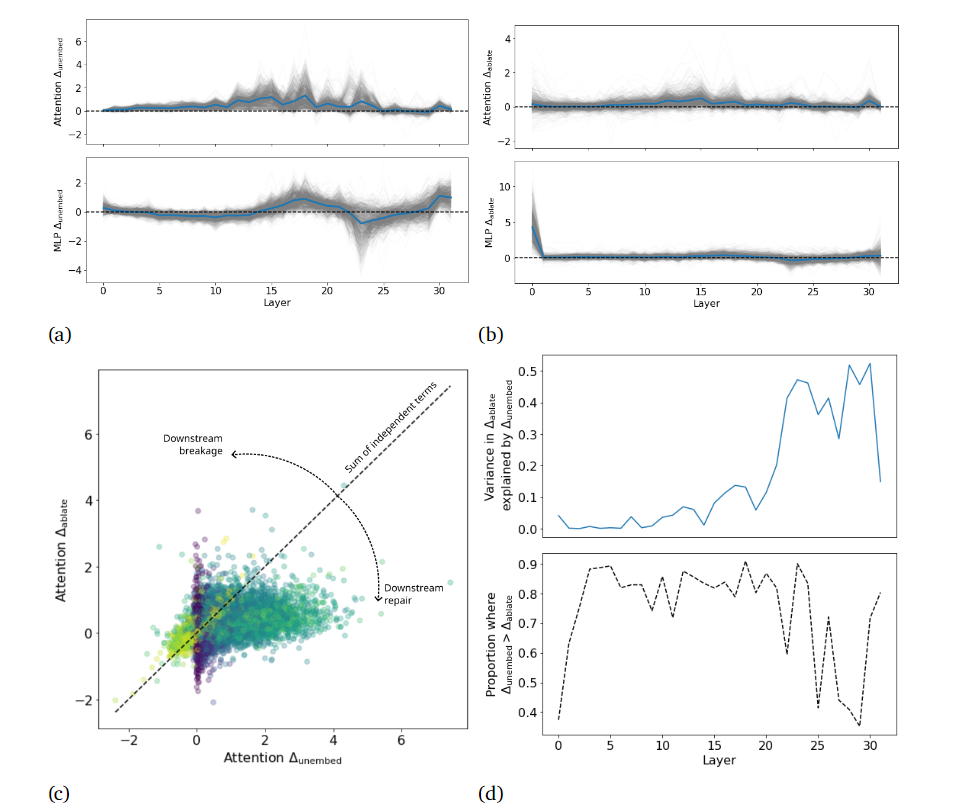
Figure 2 | Measurements of (a) unembedding-based and (b) ablation-based impact for MLP and
attention layers for a 7B parameter language model on the Counterfact dataset. Grey lines indicate
per-prompt data, blue line indicates average across prompts. (c) Comparison of unembedding- and
ablation-based impact measures across all layers showing low correlation and $\Delta_\text{unembed} > \Delta_\text{ablate}$ for most prompts and layers, contrary to expectations. (d) Quantification of correlation between Δunembed
and Δablate and proportion of prompts where $\Delta_\text{unembed} > \Delta_\text{ablate}$ across layers.

In [62]:
clean_text = cached_filtered_dataset['prompt'][0]
corrupt_text = cached_filtered_dataset['prompt'][1]

delta_ablate_l(0,clean_text, corrupt_text).shape

torch.Size([1])

In [63]:
y_values_ablate = []
i=0
for prompt in cached_filtered_dataset["prompt"][:10]:
    row = []
    i += 1  
    for layer_num in range(model.cfg.n_layers):       
        #append a value instead of a numpy array
        value = delta_ablate_l(layer_num, prompt, corrupt_text).detach().cpu().numpy()
        #convert value to a real number instead of an array
        value = value[0]
        row.append(value)
        #print(layer_num)
    y_values_ablate.append(row)
    print(i)

1
2
3
4


5
6
7
8
9
10


In [64]:
#plot the graph of delta_umbed_l across layers - plotting stuffs
y_values = []
# for each promt in the dataset, for each layer for that prompt
j = 0
for prompt in cached_filtered_dataset["prompt"][:10]:
    row =[]
    j += 1
    for layer_num in range(model.cfg.n_layers):       
        #append a value instead of a numpy array
        value = test_delta_unembed_l(layer_num, prompt).detach().cpu().numpy()
        #convert value to a real number instead of an array
        value = value[0]
        row.append(value)
    y_values.append(row)
    print(j)


1
2
3
4
5
6
7
8
9
10


In [65]:
y_values

[[9.120447, 6.943775, 7.3361936, 13.364646, 10.984535, 6.5583463],
 [10.418182, 6.373926, 7.1075845, 12.771624, 12.514104, 6.4935293],
 [9.628566, 7.1748867, 7.7209954, 12.4529505, 11.250498, 6.4699516],
 [9.096226, 7.3280344, 8.018989, 11.200491, 11.110318, 6.4719315],
 [9.393613, 6.7651434, 6.224594, 13.092754, 14.449333, 6.5868883],
 [9.393613, 6.7651434, 6.224594, 13.092754, 14.449333, 6.5868883],
 [10.718457, 5.8692927, 7.7830286, 12.277116, 11.322229, 6.6806746],
 [9.717067, 6.572843, 8.587523, 12.823213, 11.154296, 6.4460793],
 [9.083332, 7.1322484, 7.2650275, 12.498673, 10.371157, 6.65242],
 [9.45043, 6.341966, 6.7056403, 12.1221075, 8.855531, 6.512832]]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


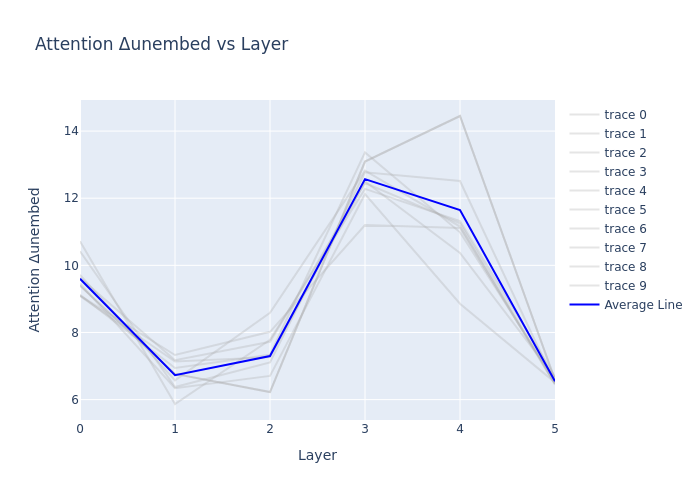

In [66]:
import plotly.graph_objects as go
import random
import numpy as np

# Generate random data for x_values and multiple y_values
x_values = list(range(model.cfg.n_layers))
#num_lines = 50  # Number of gray lines
#y_values = []

#for _ in range(num_lines):
    #y_values.append([random.randint(5, 10) for _ in x_values])

# Calculate the average y_values
average_y = np.mean(y_values, axis=0)

# Create traces for gray lines with opacity using rgba color format
gray_traces = [
    go.Scatter(
        x=x_values,
        y=y,
        mode='lines',
        line=dict(color='rgba(169,169,169,0.3)')  # Set opacity to 0.5 (semi-transparent gray)
    )
    for y in y_values
]

# Create a trace for the blue average line
blue_trace = go.Scatter(x=x_values, y=average_y, mode='lines', name='Average Line', line=dict(color='blue'))

# Create a layout for the graph
layout = go.Layout(
    title='Attention Δunembed vs Layer',
    xaxis=dict(title='Layer'),
    yaxis=dict(title='Attention Δunembed')
)

# Create a figure and add the traces to it
fig = go.Figure(data=gray_traces + [blue_trace], layout=layout)

# Show the graph (you can also save it to a file)
fig.show()

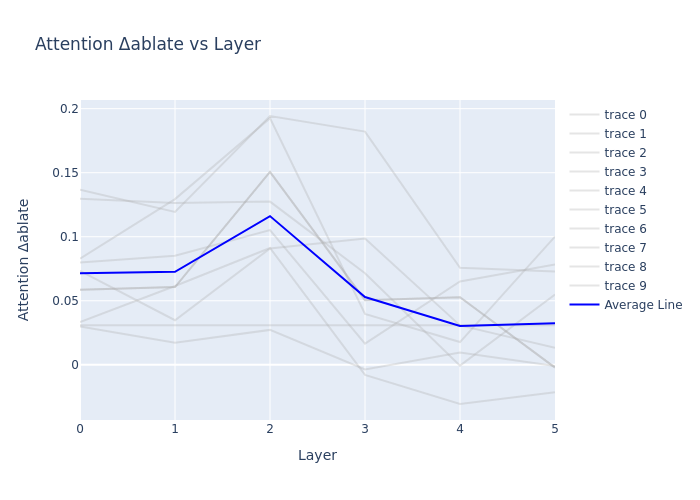

In [67]:
# Generate random data for x_values and multiple y_values
x_values = list(range(model.cfg.n_layers))
num_lines = 50  # Number of gray lines
#y_values = []

#for _ in range(num_lines):
    #y_values.append([random.randint(5, 10) for _ in x_values])

# Calculate the average y_values
average_y_ablate = np.mean(y_values_ablate, axis=0)

# Create traces for gray lines with opacity using rgba color format
gray_traces = [
    go.Scatter(
        x=x_values,
        y=y_a,
        mode='lines',
        line=dict(color='rgba(169,169,169,0.3)')  # Set opacity to 0.5 (semi-transparent gray)
    )
    for y_a in y_values_ablate
]

# Create a trace for the blue average line
blue_trace = go.Scatter(x=x_values, y=average_y_ablate, mode='lines', name='Average Line', line=dict(color='blue'))

# Create a layout for the graph
layout = go.Layout(
    title='Attention Δablate vs Layer',
    xaxis=dict(title='Layer'),
    yaxis=dict(title='Attention Δablate')
)

# Create a figure and add the traces to it
fig = go.Figure(data=gray_traces + [blue_trace], layout=layout)

# Show the graph (you can also save it to a file)
fig.show()

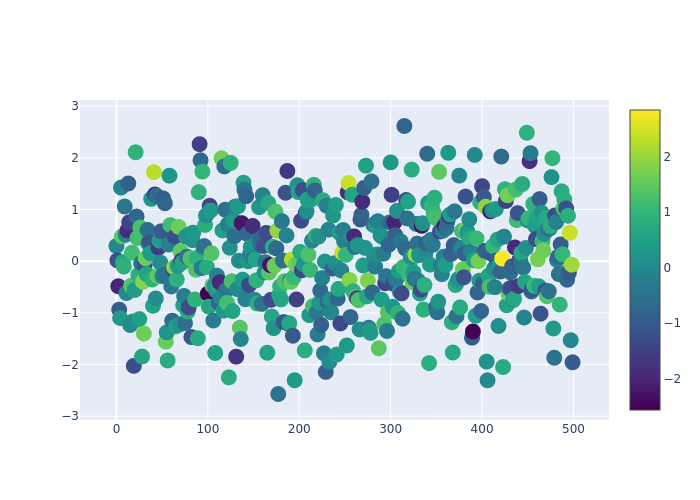

In [68]:
import plotly.graph_objects as go
import numpy as np

fig = go.Figure(data=go.Scatter(
    y = np.random.randn(500),
    mode='markers',
    marker=dict(
        size=16,
        color=np.random.randn(500), #set color equal to a variable
        colorscale='Viridis', # one of plotly colorscales
        showscale=True
    )
))

fig.show()

In [69]:
# (c) plot of delta_attention_ablate_l vs delta_attention_unembed_l, colored datapoints (by layer num? not sure)
# (d) variance in delta_ablate explained by delta_unembed: we should look up the mathematical formulation of "variance explained by X"
# (d) proportion where delta_unembed > delta_ablate
# really understanding these plots better
# it would be interesting just to plot them on pythia-70m, and see how different it is from the plots we see here, and just start to come to make conclusions
# for why it matches or why it looks completely different

### 2.5.1. Methodology

In [70]:
''' 
Should we specify pi_t_i outside or inside?
'''
clean_text = filtered_dataset['prompt'][0]
pi_t = model(clean_text)[:,-1,:]
i = torch.argmax(pi_t)


def delta_unembed_l_k(
    layer_k, # layer to ablate
    argmax_pi_t,
    where_to_patch = "hook_attn_out",
):
    ''' 
    Implementation note: takes layer_k, the layer to ablate, and where to patch
    
    fetches all u_hat(a_l_t), for all other layers l
    
    Makes runtime O(n) rather than O(n^2), n being number of layers
    '''
    # let's figure out what dimensions we should use for the output
    
    # (n_layers_l, batch, pos, d_model) this should be the shape pre-unembedding
    # (n_layers_l, batch, d_vocab) this should be the shape post-unembedding, AND pulling the argmax logit index
    
    # we need a way to get that index. So let's just run the model
    # output shape is (n_layers, n_types = 2)
    
    
    
    output = torch.zeros(model.cfg.n_layers, 2, 2) 
    _,clean_cache = model.run_with_cache(model.to_tokens(clean_text))
    
    _, cache_inner_k = resample_ablation(
        attn_out_dataset = cached_filtered_dataset, # note, fix the naming of resample_ablation argument
        layer_num = layer_k,
        cache_resid = True,
        clean_prompt = clean_text,
        sample_size = 1,
        where_to_patch = where_to_patch
        ) # we resampled one of attn_outs or mlp_outs but im not sure which one, we should have an option for this
    
    for l in range(model.cfg.n_layers):
        # cache_inner_k[f'blocks.{l}.hook_attn_out'] is shape (batch, pos, d_model)
        output[l,0,0] = u_hat(cache_inner_k[f'blocks.{l}.hook_attn_out'])[0,-1,argmax_pi_t] # runs just 1 time, since we specify k
        output[l,1,0] = u_hat(cache_inner_k[f'blocks.{l}.hook_mlp_out'])[0,-1,argmax_pi_t] # runs just 1 time, since we specify k
        output[l,0,1] = u_hat(clean_cache[f"blocks.{l}.hook_attn_out"])[0,-1,argmax_pi_t]
        output[l,1,1] = u_hat(clean_cache[f"blocks.{l}.hook_mlp_out"])[0,-1,argmax_pi_t]
        
    return output

In [71]:
sample_tensor = delta_unembed_l_k(3, i)

In [72]:
sample_tensor.shape

torch.Size([6, 2, 2])

In [73]:
sample_tensor

tensor([[[  9.1204,   9.1204],
         [ 32.8211,  32.8211]],

        [[  6.9438,   6.9438],
         [ -8.2920,  -8.2920]],

        [[  7.3362,   7.3362],
         [-12.8075, -12.8075]],

        [[ 13.3646,  13.3646],
         [ -0.6152,  -0.6152]],

        [[ 10.8819,  10.9845],
         [ 15.6460,  15.1334]],

        [[  6.5818,   6.5583],
         [ 10.4555,  10.4444]]])

In [74]:
#plot the graph of delta_umbed_l across layers - plotting stuffs
y_values = []
# for each promt in the dataset, for each layer for that prompt
j = 0
for prompt in cached_filtered_dataset["prompt"][:10]:
    row =[]
    j += 1
    for layer_num in range(model.cfg.n_layers):       
        #append a value instead of a numpy array
        value = test_delta_unembed_l(layer_num, prompt).detach().cpu().numpy()
        #convert value to a real number instead of an array
        value = value[0]
        row.append(value)
    y_values.append(row)
    print(j)
    
# y_values is a list of 10 prompt row lists of 6 elements (n_layers)

1
2
3
4


5
6
7
8
9
10


Possible sources of error

Delta\_unembed\_l\_k does not appear to be dependent on clean\_text which is by default filtered\_dataset['prompt'][0]. Furthermore, it's not clear by which method the ablation takes place. If it is controlled by resample\_ablation which randomly samples properly, then this should be working as intended, but we should check this.

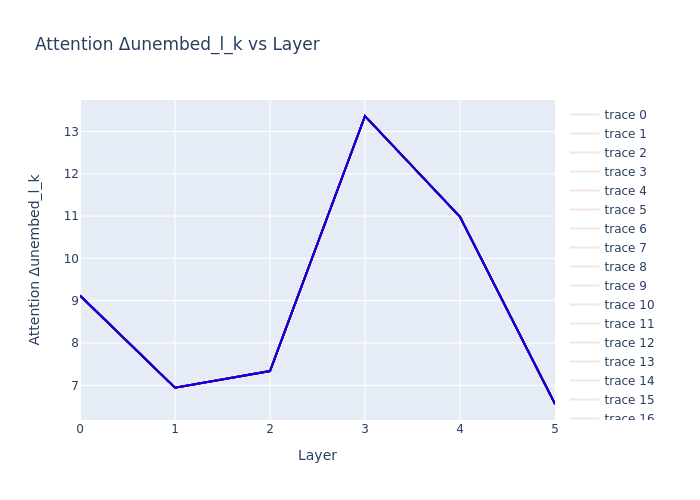

In [75]:
x_values = list(range(model.cfg.n_layers))
layer_to_ablate = 5
num_resamples = 50  # number of times to resample with sample_size=1

clean_text = filtered_dataset['prompt'][0]
pi_t = model(clean_text)[:,-1,:]
argmax_index = torch.argmax(pi_t)
_,cache = model.run_with_cache(model.to_tokens(clean_text))


y_values_k = torch.zeros(num_resamples, model.cfg.n_layers)
for p in range(num_resamples):
    y_values_k[p,:] = delta_unembed_l_k(layer_to_ablate, argmax_index)[:,0,0]

# convert y_values_k to a list of 50 lists of 6 elements (n_layers)
y_values_list = []
clean_values_list = []

for l in range(num_resamples):
    row = []
    for k in range(model.cfg.n_layers):
        row.append(y_values_k[l,k].item())
        if l == 0:
            clean_values_list.append(u_hat(cache[f"blocks.{k}.hook_attn_out"])[0,-1,argmax_index].item())
    y_values_list.append(row)  # list of n_samples by n_layers 
    


# Create traces for gray lines with opacity using rgba color format
red_traces = [
    go.Scatter(
        x=x_values,
        y=y_k,
        mode='lines',
        line=dict(color='rgba(169,0,0,0.1)')  # Set opacity to 0.5 (semi-transparent red)
    )
    for y_k in y_values_list
    
    # fetch 
]


# Create a trace for the blue average line
blue_trace = go.Scatter(x=x_values, y=clean_values_list, mode='lines', name='Average Line', line=dict(color='blue'))

# Create a layout for the graph
layout = go.Layout(
    title='Attention Δunembed_l_k vs Layer',
    xaxis=dict(title='Layer'),
    yaxis=dict(title='Attention Δunembed_l_k')
)

# Create a figure and add the traces to it
fig = go.Figure(data=red_traces + [blue_trace], layout=layout)

# Show the graph (you can also save it to a file)
fig.show()


Where are we going wrong with the delta_unembed_l_k?
- unembedding map could be different across prompts? sounds weird, would only be the case if we're using a later layer's unembedding map for earlier layers (hard)


torch.Size([6, 2, 2])


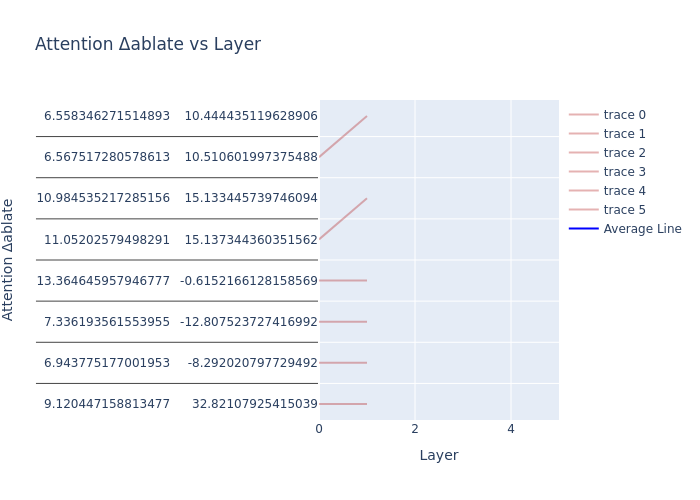

In [76]:
x_values = list(range(model.cfg.n_layers))
num_resamples = 10  # number of times to resample with sample_size=1


#average_y_ablate = np.mean(y_values_ablate, axis=0)
layer_to_ablate = 3
# y_values_k = delta_unembed_l_k(layer_to_ablate, i) #.detach().cpu().numpy()

y_values_list = []
for l in range(num_resamples):
    y_values_k = delta_unembed_l_k(layer_to_ablate, i)
    row = []
    for layer_num in range(model.cfg.n_layers):
        #y_values_list.append(delta_unembed_l_k(layer_to_ablate, i))
        y_values_list.append(y_values_k[layer_num,:])
    
    
print(y_values_k.shape)

# Create traces for gray lines with opacity using rgba color format
red_traces = [
    go.Scatter(
        x=x_values,
        y=y_k,
        mode='lines',
        line=dict(color='rgba(169,0,0,0.3)')  # Set opacity to 0.5 (semi-transparent red)
    )
    for y_k in y_values_k
    
    # fetch 
]


# Create a trace for the blue average line
blue_trace = go.Scatter(x=x_values, y=average_y_ablate, mode='lines', name='Average Line', line=dict(color='blue'))

# Create a layout for the graph
layout = go.Layout(
    title='Attention Δablate vs Layer',
    xaxis=dict(title='Layer'),
    yaxis=dict(title='Attention Δablate')
)

# Create a figure and add the traces to it
fig = go.Figure(data=red_traces + [blue_trace], layout=layout)

# Show the graph (you can also save it to a file)
fig.show()


In order to understand the mechanism behind the difference in results from ablation and unembedding methods we propose a simple methodology that allows us to localise changes in network computation. First, for each input $x_{\leq t}$ we compute attention and MLP outputs $a^l_{t}(x_{\leq t})$ and $m^l_{t}(x_{\leq t})$ for all layers $l$. We refer to this as the clean run, matching the terminology from (Meng et al., 2022). We then compute the unembedding-based impact $\Delta_{\mathrm{unembed}, l}$ as defined in Section 2.3.1. This gives us a per-layer measure of the impact of each layer on the maximum-likelihood logit in the clean run. We then ablate a specific attention or MLP layer $k$ using resample ablation (see Appendix A). We refer to this as the layer $k$ ablation run. We now compute $\Delta_{\mathrm{unembed}, l}$ for each layer $l$ and layer $k$ ablation run. We denote a specific unembedding layer $l$ and ablation layer $k$ by $\tilde{\Delta}^{k}_{\mathrm{unembed}, l}$:
\begin{equation}
    \tilde{\Delta}^k_{\mathrm{unembed}, l} = u\left(a^l_t\,|\,\mathrm{do}(A^k_t = \tilde{a}^k_t)\right)_i \quad i = \text{arg max}_j[\pi_t]_j. \tag{13}
\end{equation}
Because the transformer network is a feedforward network, if a readout layer $l$ is not causally downstream of the ablation layer $k$ then $\tilde{\Delta}^{k}_{\mathrm{unembed}, l} = \Delta_{\mathrm{unembed}, l}$. If $k=l$ then $\tilde{\Delta}^{k}_{\mathrm{unembed}, l}\approx 0$ because the output of that layer will be ablated (the approximate equality is due to the fact that the resample ablation is stochastic and so may not fully zero out the centred logit of the maximum-likelihood token).  

This methodology, depicted in Figure 1, measures the impact of each layer on the maximum-likelihood token before and after ablation. This allows us to determine how individual layers react to a given ablation.  
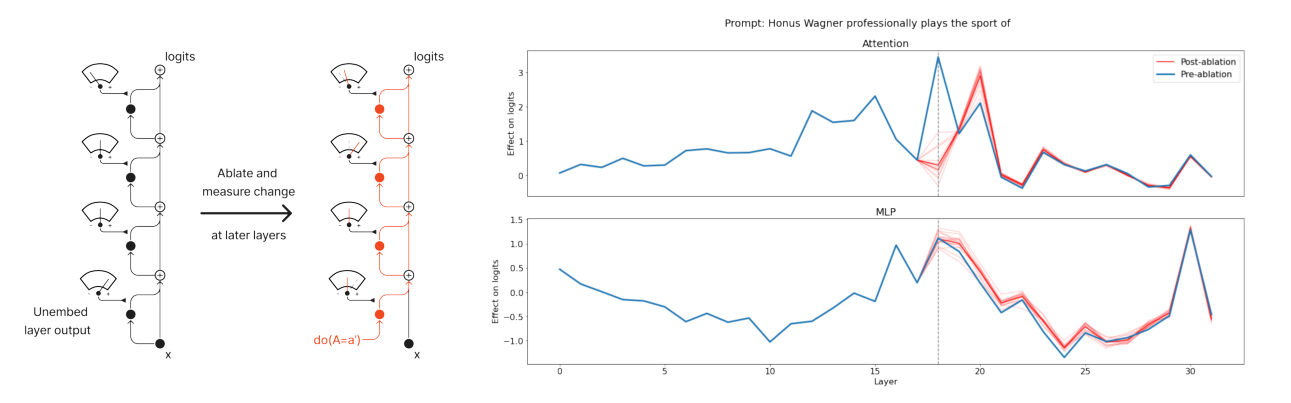  
Figure 1 | The
blue line indicates the effect on output logits for each layer for the maximum-likelihood continuation
of the prompt shown in the title. Faint red lines show direct effects following ablation of at a single
layer indicated by dashed vertical line (__attention layer 18 in this case__) using patches from different
prompts and the solid red line indicates the mean across patches.

### 2.5.2 Results

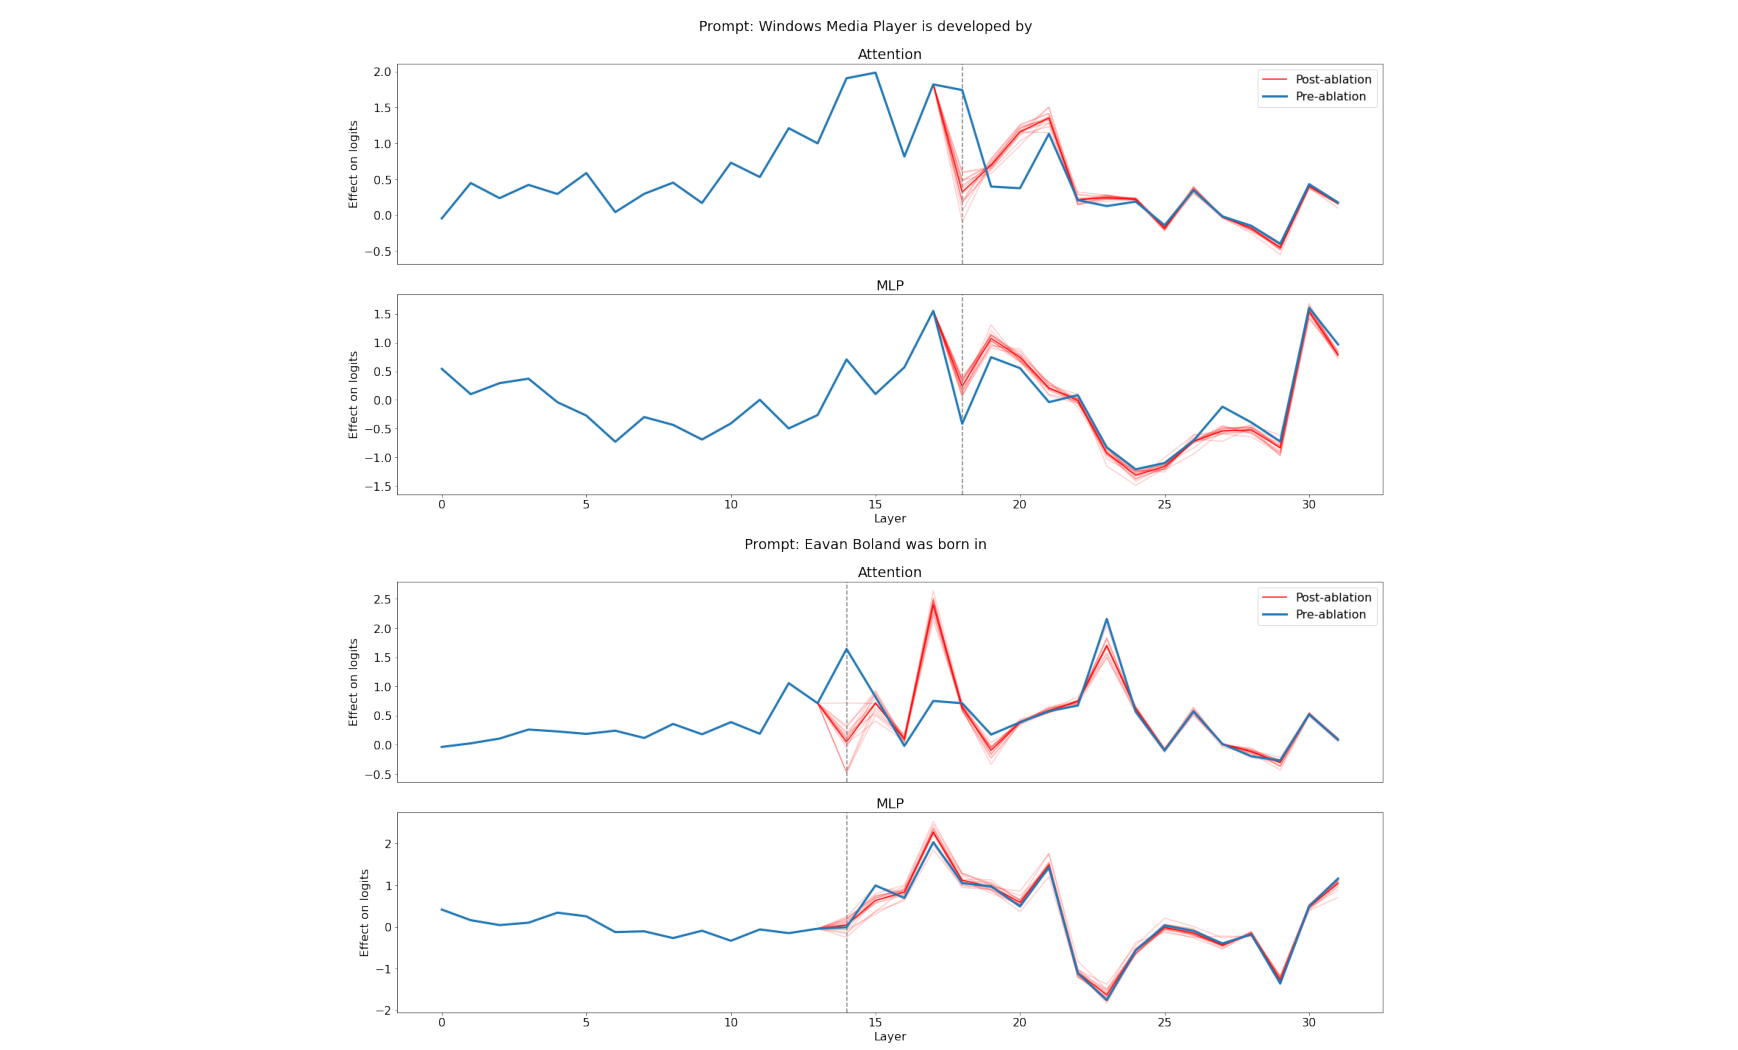
Figure 3 | Example results of self-healing computations in Chinchilla 7B showing per-layer impact on
final logits before and after ablation.

Sample results for attention ablation are shown in Figure 1 and Figure 3 showing ablations of layers with high $\Delta_{\mathrm{unembed}}$. Several observations stand out from this data:

**Resample ablations work but are noisy:** Resample ablations successfully reduce $\Delta_{\mathrm{unembed}}$ of the ablated layer to approximately zero when averaged across patches, although there is substantial variance between the effect of each patch. This demonstrates that resample ablations can provide true ablations but require a reasonably large sample size to prevent excessive noise.

**The Hydra effect occurs in networks trained without dropout:** In both cases an attention layer downstream of the ablated layer (layer 20 in the examples shown) substantially \textit{increases} its impact in the ablated network compared to the intact network, i.e. $\tilde{\Delta}^m_{\mathrm{unembed}, l} > \Delta_{\mathrm{unembed}, l}$ for some unembedding layer $l > m$. These are examples of the Hydra effect: we cut off some attention heads, but others grow their effect to (partially) compensate. The Chinchilla-like language model we study here was trained entirely without dropout, stochastic depth, or layer dropout.

**Downstream effects of ablation on attention layers are localised:** The effects of attention ablation on downstream layers are localised: apart from the subsequent attention layer involved in the Hydra effect, other attention layers have $\Delta_{\mathrm{unembed}}$ almost entirely unchanged in the ablated network. This does not necessarily imply that the features that would have been created by the ablated layer are unused in later layers, however (although it is consistent with this hypothesis). It is possible that the Hydra effect is not just compensating for the impact of the ablated layer on logits, but is also replacing the missing features that the ablated layer would have provided. More detailed multiple ablation studies would be needed to distinguish between these hypotheses.

**Downstream MLPs may perform erasure/memory management:** The shape of the unembedding impact curve across layers for the MLP layers remains very similar, but the impact of many of the layers is attenuated. This suggests that these MLPs are performing an erasure/memory-management role: when the attention layer has a high positive impact they have a high negative impact and when the attention layer's $\Delta_{\mathrm{unembed}}$ is reduced theirs is similarly attenuated.
\newline\newline

Although these observations are surprising, the evidence we have presented here is largely anecdotal. Before expanding our analysis to the full Counterfact dataset and analysing all layers in Section 4 we first introduce basic tools of causal inference and reframe our analyses in terms of concepts from causality in Section 3.

In [ ]:
# do a status update ONLY up to this point
# can we find similar results on ANY of the pythia models?

# 3. Neural networks as causal models: the compute graph is the causal graph

TODO:
- Implement Total effect (3.1)
- Implement Direct effect (3.2)
- Implement Indirect effect (3.3)
- Check the math on indirect math RE: RMSNorm vs Layernorm

## 3.0: This section is all text and notation. There is no code here.

(except for possibly implementing Y(do ...))

This section introduces structural causal models, causal graphs and the idea of interventions. The
central idea of this section is that we can consider the internal structure of neural networks as
structural causal models and use tools from causality to analyse their internal workings. One thing
we are not claiming is that neural networks are naturally forming causal models of their training data,
or that networks learn to perform causal reasoning - the degree to which this happens in practice or
forms the basis for successful generalisation is still not well understood.

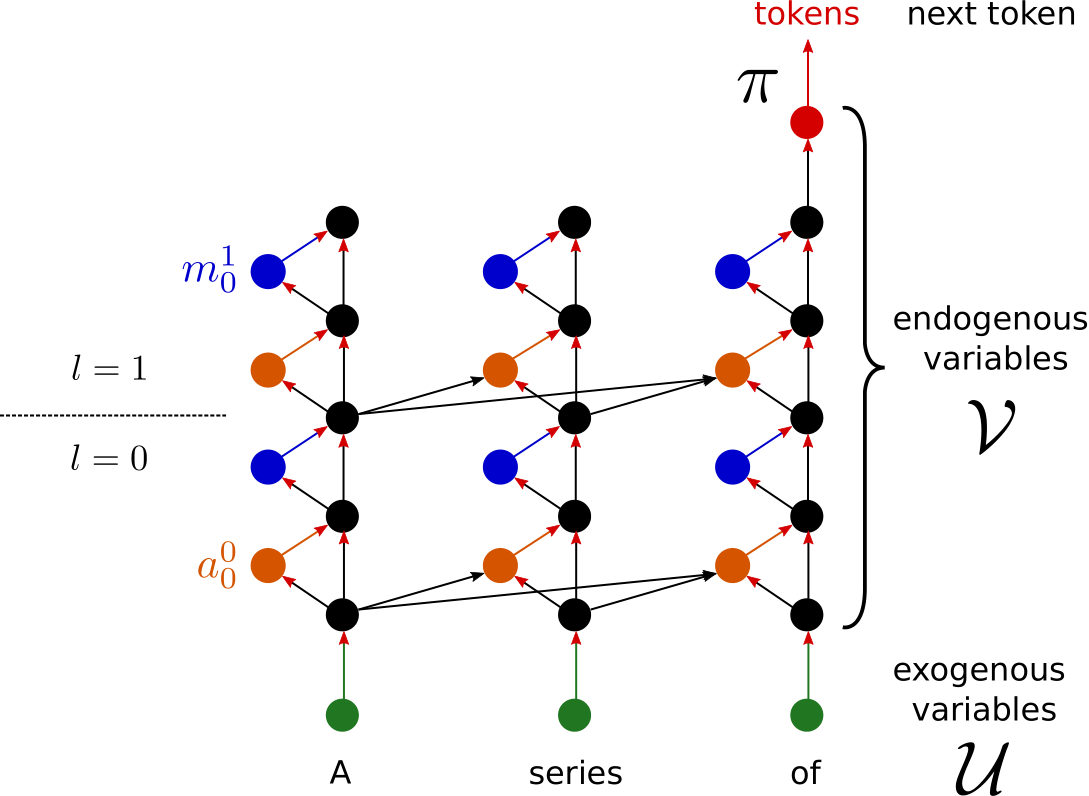

Figure 4 | Viewing a transformer network as a structural causal model.

In [ ]:
'''
Some explanations about this diagram and the following section
The diagram isn't exactly correct, all the U tokens would feed into an attention layer (since the QK operates across position)
I suppose MLP is correct technically given that it operates on each position independently

U : context / vocabulary space / embedding space
V : residual stream, attn_out, mlp_out, mlp_in, ... print(cache) for all options here


When they do do(Z = z'), they picking some location in the cache options for V, and patching in z', some alternate value
for Y(do blah blah blah), Y also lives in this same cache options space for V.
'''

**Causal models**

**Definition 3.1** (Causal model). A structural causal model $M$ is a tuple $M = ⟨U, V, F, P(u)⟩$ where:
1. $U$ and $V$ are sets of variables called the exogenous and endogenous variables respectively.
We follow the standard convention of writing a random variable in uppercase and a specific
realisation of that variable in lowercase, so $u$ is a realisation of the exogenous variable $U$.
2. $F$ is a set of deterministic functions where $f_i \in F$ determines the value of $V_i$ from a subset of variables $\text{Pa}_i \in U \cup V \setminus \{V_i\}$, i.e. $\nu_i = f_i(\text{pa}_i)$.
3. $P(u)$ is a probability distribution over exogenous variables $U$.

In a structural causal model the exogenous variables $U$ represent randomly-set external conditions
(the 'context') and the endogenous variables $V$ follow deterministically from the context $u$. Given
a setting of exogenous variables $U = u$, the value of an endogenous variable $V_i$ is fully determined.
We write the value $V_i$ takes in this situation as $V_i(u)$ to reflect this rather than write the full set of
functions relating $V_i$ to $U$ for conciseness and generality.

We can visualise structural causal models as directed graphs where an edge $X_i \to X_j$ (for $X_i, X_j \in U \cup V$ exists if $X_i \in \text{pa}_i$, i.e. if $X_i$ is one of the variables that directly determines the value of $X_j$. The
important factor distinguishing $U$ from $V$ is that variables in $U$ have no in-edges: there is nothing
apart from the probability distribution $P(u)$ that determines their value. Variables in $V$, on the other
hand, can eventually trace their ancestry back to one or more values in $U$ (although in large models it
may take many edges to do so).

In [ ]:
# make sense of what Y(u | do(Z=z')) is, and implement if necessary
'''
do(corrupt thing).cache values
Y(u | do(Z=z')) = those cache values after running on corrupt pass

yes make the Y method
should take in a hook for value to keep track of, Z hook thing for do patching intervention
'''

"\ndo(corrupt thing).cache values\nY(u | do(Z=z')) = those cache values after running on corrupt pass\n\n"

**Interventions & counterfactuals in causal models**   
In a causal model an intervention $\text{do}(Z = z')$
alters the value of an endogenous variable $Z$ from whatever value it would have taken based on
its parents $z = f_Z(\text{pa}_Z)$ to the new value $z'$. This entails a change in the causal model $M$ to a new
intervened-upon model $M_Z$ where $M_Z$ is identical to $M$ except that $f_Z(\text{pa}_Z)=z'$ regardless of the values taken by $\text{pa}_Z$: the function $f_Z$ has been replaced by a constant function returning $z'$. In terms of the
causal graph this leads to a removal of in-edges to $Z$ (as it no longer depends on other elements of the
graph) and the addition of a new intervention edge (see Figure 5 for some examples). We express
this intervention using the do-operator (Pearl, 2009), where $Y(u \mid \text{do}(Z = z'))$ denotes the value that
𝑌 takes in the modified model $M_Z$ given the context $u$.

TODO: include Figure 5 image & caption

**Treating language models as causal models**   
Given these preliminaries the correspondence between
neural networks and structural causal models is hopefully clear: the input data $x$ correspond to
the exogenous variables $U$ and the network’s activations $(z, a, m)$ and outputs $\pi$ correspond to the
endogenous variables $V$. In autoregressive transformer-based language models causal masking ensures
that activations at input position $t_1$ are never causal parents of activations at input position $t_2$ if $t_1 > t_2$.

For the remainder of this work we will assume a standard Transformer architecture, as shown in
Figure 4. Intervening on neural networks is identical to intervening in a SCM: we set the nodes
to their intervention values and propagate the effects of this intervention forwards. Although for
concreteness we focus on language modelling using transformers, the general framework of causal
analysis is applicable to deterministic feedforward neural networks more generally - all that changes is
the structure of the graph. Stochastic networks such as VAEs or diffusion models can be incorporated
by adding additional exogenous nodes corresponding to sources of noise.

## 3.1 Direct, indirect, and total effects

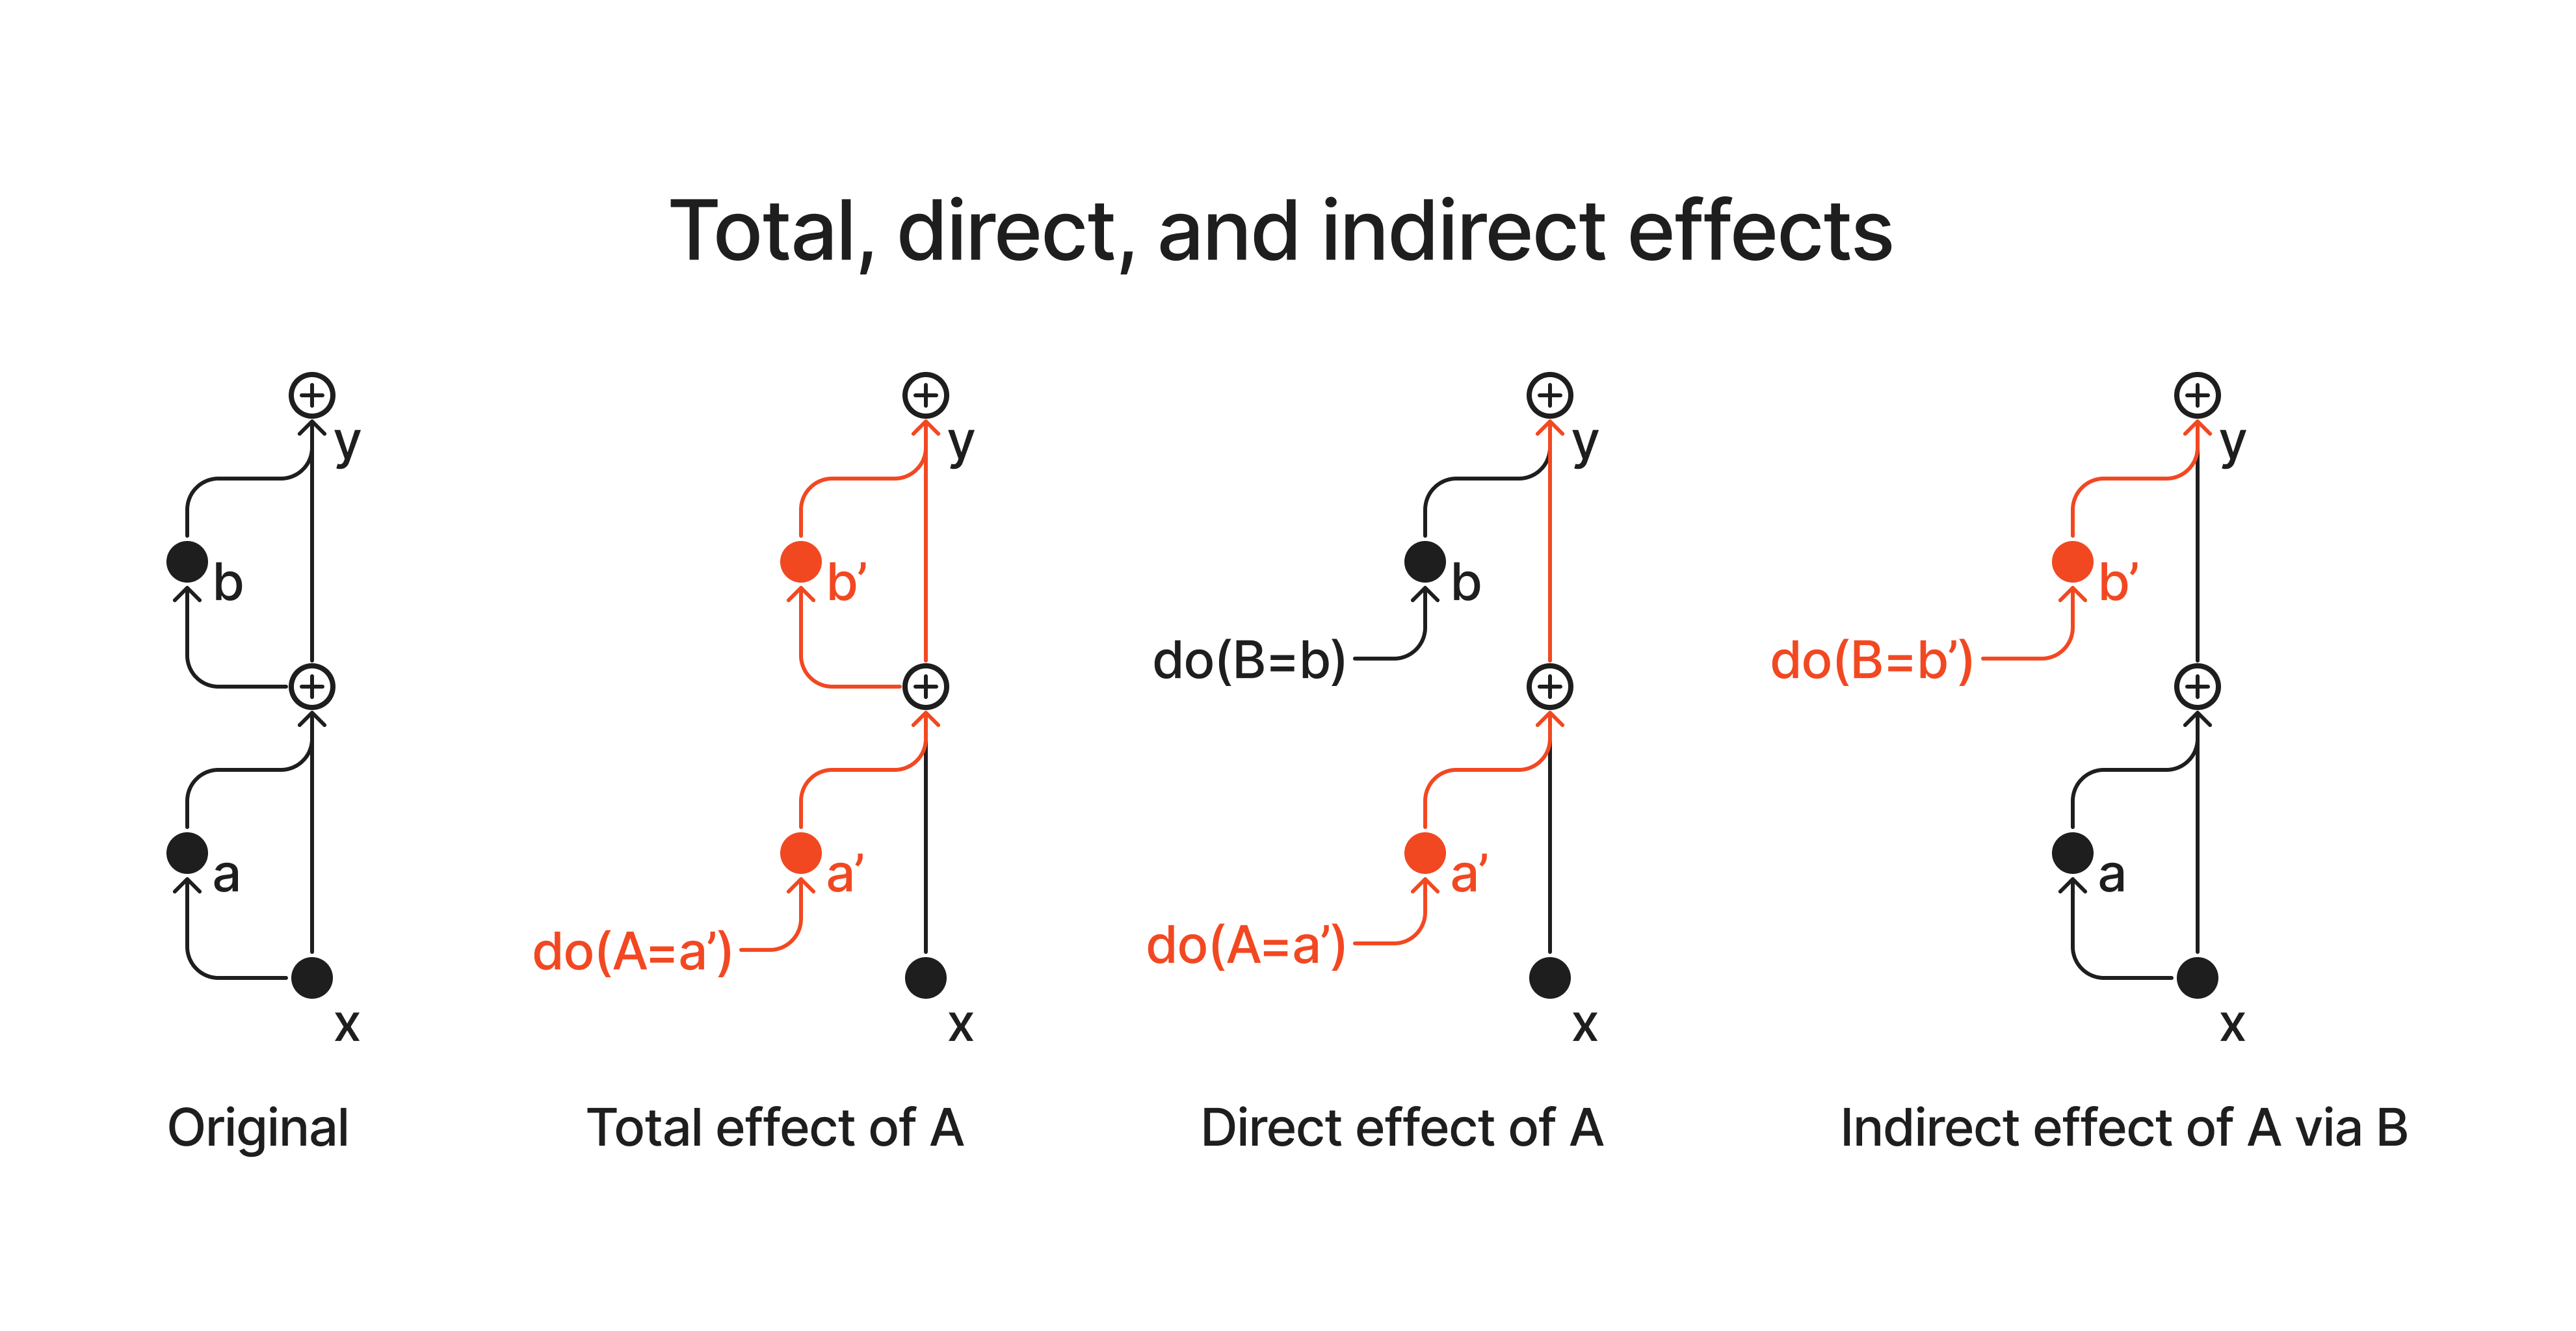
Figure 5 | Interventions and types of effect illustrated with a two-layer residual network example.
The total effect involves intervening on a node and allowing the changes due to that intervention to
propagate arbitrarily, whereas the direct effect only allows those changes to propagate via the direct
path between intervention and output. The indirect effect is the complement of the direct effect:
effects are allowed to flow via all but the direct path.

We now have the notation and concepts needed to define and compute several important types of
effects in causal graphs: the total, direct, and indirect effects. When we define the different types of
effect in a causal model we will always consider the effects in a given context (i.e. a given setting of
exogenous variables $u$).

### 3.1.0 Code implementations of all 3

In [59]:
# implement total_effect

      
def total_effect(
    #we decide which activation to patch - choices are pick a layer and pick whether its attention or mlp
    # total choice of num_layers x 2 possible activations to corrupt
    # 
    layer_num,
    clean_text,
    corrupt_text,
    where_to_patch = "hook_attn_out",
):
    '''
    delta_ablate(x <= t)
    return clean_pass_cache[endogenous_variable] - corrupt_pass_cache[endogenous_variable]
    The paper only ever uses Y = pi_t, so there's no reason to implement anything else for now
    '''
    return delta_ablate_l(layer_num,clean_text,corrupt_text,where_to_patch)


In [60]:
# implement total_effect, generalized version

      
def total_effect_generalized(
    Z,
    Y, # such as pi_t_fn
    z_prime, # corrupt patch
    z, # clean patch
):
    '''
    Y(u, do(Z=z')) - Y(u, do(Z=z)
    '''
    pass

In [ ]:
# implement direct_effect
def direct_effect(
    # clean_pass_stack
    # corrupt_pass_stack
    # endogenous_var
):
    '''

    return clean_pass_cache[endogenous_variable] - corrupt_pass_cache[endogenous_variable]
    '''
    pass

In [ ]:
# implement indirect_effect
def indirect_effect(
    # clean_pass_stack
    # corrupt_pass_stack
    # endogenous_var
):
    '''
    return clean_pass_cache[endogenous_variable] - corrupt_pass_cache[endogenous_variable]
    '''
    pass

### 3.1.1 Total effect
**Definition 3.2** (Total effect). The total effect of altering a value of a variable $Z$ from $Z=z$ to $Z=z'$ in a context $u$ is given by
$$TE(z \to z', Y, u) = Y(u \mid \text{do}(Z = z')) - Y(u \mid \text{do}(Z = z)) \tag{14}$$

Here in the above, u is a context so we assume u = x <=t

**Total effect corresponds to ablation-based impact**   
If we choose $Y = \hat{\pi}_t$ (i.e. the random variable
we measure the effect of the intervention on is the centred logit of the maximum-likelihood token $i$ at
the final token position 𝑡) and the exogenous variables are the prompt $u = x_{\leq t}$ then the total effect of an intervention to change activations $A_t^l$ from their ‘natural’ $a_t^l(x_{\leq t})$ to an intervened-upon value $\tilde{a}_t^l = a_t^l(x_{\leq t}')$ is

\begin{align}
    TE(a_t^l \to \tilde{a}_t^l, [\hat{\pi}]_i, x_{\leq t}) = & \left[\hat{\pi}_t(x_{\leq t}|\text{do}(A_t^l = \tilde{a}_t^l))\right]_i - \left[\hat{\pi}_t(x_{\leq t} \mid \text{do}(A_t^l = a_t^l))\right]_i \tag{15}\\
    = & \left[\hat{\pi}_t(x_{\leq t}|\text{do}(A_t^l = \tilde{a}_t^l)) - \hat{\pi}_t(x_{\leq t} \mid \text{do}(A_t^l = a_t^l))\right]_i \tag{16}\\
    = & \left[\hat{\pi}_t(x_{\leq t}|\text{do}(A_t^l = \tilde{a}_t^l)) - \hat{\pi}_t(x_{\leq t})\right]_i \tag{17}\\
    = & \Delta_{\text{ablate},l}(x_{\leq t}) \tag{18}
\end{align}
where we go from Equation 2 to 3 by using the fact that the intervention $\text{do}(A_t^l = \tilde{a}_t^l)$ doesn’t change $A_t^l$ from the value it would have taken in the context $x_{\leq t}, as in Section 2.4.1. This shows that
our ablation-based impact measure corresponds to measuring the total effect due to a change from
the natural activation distribution to one sampled from the ablation distribution. The total effect of
ablation (knockout) measures the importance of a unit in a given inference: if we were to ablate
it, how much would performance suffer if the effects of the ablation were to cascade through the
network.

In [ ]:
# implement direct_effect
'''
What i *think* is happening is
do(Z = z', M = m(u)) just means

let's say Z = attention layer 1
do(Z = z', M = m(u)) - Y(u | do (Z=z))
means attn_layer(z') - attn_layer(z)

keep this in mind when we get back to this section, might not want to implement it directly into do_fragile's functionality
'''

### 3.1.2 Direct Effect
**Definition 3.3** (Direct Effect). The direct effect of altering $Z=z \to Z=z'$ is given by

$$DE(z \to z',Y,u) = Y(u \mid \text{do}(Z=z',M=m(u))) - Y(u \mid \text{do}(Z=z))\tag{19}$$ 

i.e. the effect of intervening to set $Z=z'$ and then resetting all other variables $M = V \setminus \{Z,Y\}$ to the value they would have obtained in the context $u$. As with the total effect, if $z = z(u)$ then the direct effect reduces to
$$DE(z \to z',Y,u) = Y(u \mid \text{do}(Z=z',M=m(u)))-Y(u) \tag{20}$$

The direct effect measures how much changing the unit’s value would affect the output if all
other units’ values were held constant. Because of this, in a language model only units connected
via a residual path to the output (i.e. at the same token position) can have a direct effect - all other
units must have their effect mediated by at least one attention head in order to cross between token
positions. The residual structure of our language models means that effects on logits are additive
(up to a normalisation constant introduced by RMSNorm), and so every change in logits eventually
occurs due to a direct effect.

In [ ]:
# implement indirect_effect

IF you say the layernorm "constant" is set to some value c
Then layernorm itself is a linear transformation

This never happens in practice. You can't "set" the constant to some value, because it's calculated using the variance of the values in its input x   
Each layer's layernorm will then have a different variance because it's in a different location of processing  

How different will they be? No idea

IF we fix the layernorm in question to have a specific value c, let's say the variance of the last layer's activations  
Then all previous layernorms are actually linear transformations, the same linear transformation, with respect to it  

This is the setting of the following block of math

Direct effect is not identically equal to unembedding based impact: recall that unembedding impact is Layernorm applied to cached hook\_attn\_out, that is the outputs of the attention layer (or mlp layer) at layer l. And the layernorm that we calculated there was relative to the values in hook\_attn\_out, and thus will differ from the assumption made here by the scaling factor computed by 

PERSONALLY i want to see what the variance itself is across layers on different inputs. We could implement this at some later point in time

Notes for future selves: The DIFFERENCE between Direct Effect \& delta\_unembed\_l is the aggregate of the differences between the local variance \& the last layer variance. So this would measure how bad of an approximation it is. But we could also just separately plot the layernorm variances.

### 3.1.3 Unembedding-based impact with RMSnorm held constant approximates direct effect


**TODO: check if the equivalent of this holds for LayerNorm rather than RMS norm**
To see the relation between the unembedding-based impact $\Delta_{\mathrm{unembed}, l}$ and the direct effect of an attention variable $A^l_t$ on the logits $\hat{\pi}_t$ in context $x_{\leq t}$ we first rewrite the architecture defined by Equations 3-6 (missing reference) in the 'unrolled view' introduced by (Veit et al., 2016) (for more details on this mathematical perspective on transformers see (Elhage et al., 2021):
\begin{align}
    z^L_t(x_\leq{t}) = \sum^L_{l=1}m^l_t(x_{\leq t}) + a^L_t(x_{\leq t}), \tag{21}
\end{align}
where $L$ is the final layer of the network and we leave the dependence of activations at layer $L$ on earlier layers implicit. To get the logits we simply unembed $z^L_t$:
\begin{align}
    \pi_t(x_{\leq t}) &= \mathrm{RMSNorm}(z^L_t)W_U \tag{22} \\
    &= \frac{z^L_t(x_\leq{t})}{\sigma(z^L_t)}GW_U \tag{23}\\
    &= \frac{1}{\sigma(z^L_t)}\sum^L_{j=1}\left[m^j_t(x_{\leq t}) + a^j_t(x_{\leq t})\right]GW_U,\tag{24}
\end{align}
where $G$ is the RMSNorm gain matrix and $W_U$ is the unembedding matrix (see Sections 2.1 and 2.4.1). Equation 24 demonstrates that the logits (and thus the centred logits $\hat{\pi}$) are linear in the layer outputs so long as the RMSNorm scale factor $\sigma(z^L_t)$ is held constant. Now we can compute the direct effect of ablating attention layer output $a^l_t$ on the logits (we omit centring as in Equation 9 here for brevity, but it is trivial to include):
\begin{align}
    DE(a^l_t\to\tilde{a}^l_t, \pi_t, u) &= \left[\pi_t(x_{\leq t} |\mathrm{do}(A^l_t=\tilde{a}^l_t, M=M(x_{\leq t}))) - \pi_t(x_{\leq t})\right]_i \tag{25}\\
    &=\left[\frac{1}{\sigma(z^L_t)}\left(\tilde{a}^l_t + m^l_t(x_{\leq t}) + \sum^{L}_{j\neq l}\left[m^j_t(x_{\leq t}) + a^j_t(x_{\leq t})\right] - \sum^L_{j=1}\left[m^j_t(x_{\leq t}) + a^j_t(x_{\leq t})\right]\right)GW_U\right]_i \tag{26}\\
    &= \left[\frac{\tilde{a}^l_t - a^l_t(x_{\leq t})}{\sigma(z^L_t)}GW_U\right]_i \tag{27}\\
    &= u(\tilde{a}^l_t)_i - u(a^l_t(x_{\leq t}))_i. \tag{28}
\end{align}

*Implementation footnote: Are equation references possible? I think a decent approximation is fixing the begin{align} numbering, and at least make them accurate

The only difference (up to centring) between the direct effect computed above and $\Delta_{\mathrm{unembed}, l}$ is the inclusion of the impact of the ablation on the maximum-likelihood token $u(\tilde{a}^l_t)_i$. This factor is typically negligible if the source of resample ablations are chosen correctly (otherwise the ablation would still be substantially increasing the probability of the maximum-likelihood token) and is zero in the case of zero ablations, in which case $\Delta_{\mathrm{unembed}, l} = DE(a^l_t\to\tilde{a}^l_t, \hat{\pi}_t, u)$.

### 3.1.4 Indirect Effect
**Definition 3.4** (Indirect Effect). The indirect effect of altering $z \to z'$ is given by
$$IE(z \to z',Y,u) = Y(u \mid \text{do}(Z=z,M=\tilde{m})) - Y(u \mid \text{do}(Z=z)); \quad \tilde{m} = m(x_{\leq t}')$$

Indirect effect measures the effect that a unit has via downstream units, i.e. variables that are on
the path from $Z$ to $Y$ (we say a variable $M$ satisfying this criterion _mediates_ the relationship between $Z$ and $Y$). Units inside a circuit that is important in the current context will have high indirect effect,
whereas units at the terminus of the circuit will have high direct effect. When we don’t specify the
mediating variables we assume that all variables between the intervened variables and the output
variables are changing.

## 3.2 Challenges and opportunities in intervening in neural networks

In [ ]:
# future direction: mlp directions via dictionary learning?
# do not get nerd sniped by this, we should just delegate to HAL

The difficulties and affordances involved in performing causal analysis on neural networks are almost
the opposite of those involved in most real-world causal analysis: we know the causal model with
complete certainty (down to the level of individual parameters), can perform arbitrarily long chains
of interventions rapidly and can read the value of all variables simultaneously. On the other hand, our
causal models involved enormous numbers of individual parameters, and these parameters have no
obvious meaning attached to them (with the exception of input and output variables). Painstaking
analysis often suggests meanings for individual neurons or clusters of neurons (Bau et al., 2018;
Carter et al., 2019; Goh et al., 2021; Hilton et al., 2020) but the correct unit of analysis still remains
unclear (Morcos et al., 2018). A recent line of work on a phenomenon known as superposition has
begun to shed some light on how directions in activation space relate to meaningful units of analysis
(Elhage et al., 2022) but this work has yet to reach any definitive conclusions that allow us to decide
how to group neurons to reduce the size of the graph. For this reason we work with ablations at the
level of individual layers, while acknowledging that this level of analysis is still likely to be too coarse
to capture all the relevant phenomena.

## 3.3 Toy model and motif for the Hydra effect

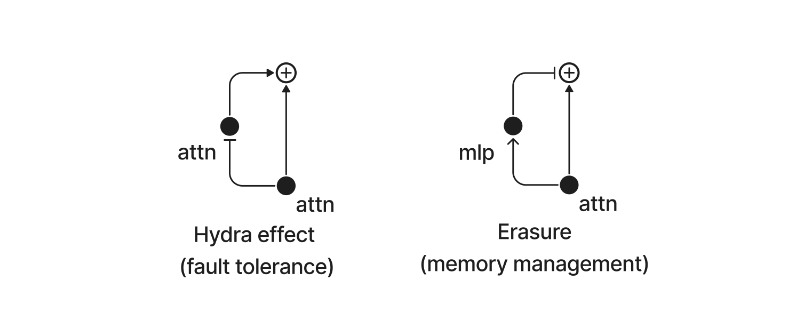  
Figure 6 | Network motifs that cause total and direct effect to be uncorrelated, either by self-repair or
erasure. An arrow-ended line $X \to Y$ indicates that X increases Y whereas a bar-ended line indicates
that 𝑋 inhibits 𝑌

The use of probes to analyse neural network training originated in (Alain and Bengio, 2016), and
has been widely used since. In the context of transformer language models the ‘logit lens’ approach,
which involves using the model’s own unembedding matrix to decode the residual stream, has been
applied to early GPT models (nostalgebraist, 2020). In order to better align with the model’s true outputs Belrose et al. (2023) use a learned affine unembedding rather than the model’s unembedding
matrix and are also able to perform causal interventions using a learned ‘causal basis’. Geva et al.
(2022b) and follow-on work (Dar et al., 2022; Geva et al., 2022a) analyse MLP layers by unem-
bedding specific subspaces of their outputs. Sparse probing has been used to empirically study the
superposition phenomenon (Elhage et al., 2022) in large language models (Gurnee et al., 2023) and
has been used to understand concept learning in deep reinforcement learning agents (Forde et al.,
2022; McGrath et al., 2022).

We now turn the tools of causal inference that we have just introduced to our findings on self-repair
by studying a simplified toy model of the phenomena we observed in Section 2. These toy models
both use a simple causal model involving a single exogenous variable $u$ and endogenous variables $x(u)=u$ and $y$:
$$y = x(u) + f(x,u)$$
If we intervene to set $x=0$, what functions $f$ will ensure that the total effect $TE(x,y)$ is zero? Two
simple possibilities stand out:
$$f(x,u) = -x \quad (\text{Erasure})$$
which will ensure that $y=0$ regardless of the input variable $u$, or
$$f(x,u) = \begin{cases}
			0, & \text{if $x=u$}\\
            u, & \text{otherwise}
		    \end{cases} \quad
(\text{Self-repair})$$   

In both cases the output variable 𝑦 is kept unchanged regardless of the inner workings of the model,
but in the erasure case it is clamped to zero whereas in the self-repair case it is fixed at 𝑢. Although
these simple circuits are stylised in order to illustrate a point, they turn out to be surprisingly good
models of phenomena we observe in real language models.

# 4. Quantifying erasure and the Hydra Effect

## 4.1 Methodology

In [ ]:
# implement DE_ablated



# implement CE = compensatory_effect

$$DE(z \to z',Y,u) = Y(u \mid \text{do}(Z=z',M=m(u))) - Y(u \mid \text{do}(Z=z))\tag{19}$$ 

For a given context $u$ we can measure the total compensatory effect following an ablation $\tilde{a}^m$ by summing the effects of the downstream changes in the network:
$$CE_{perm}(\tilde{a}^m,u) = \sum_{l=m+1}^L \Delta DE(\tilde{a}^m,a^l,u) + \sum_{l=m}^L \Delta DE(\tilde{a}^m,m^l,u)$$

where $DE_{\text{ablated}}(z^l, u, \tilde{z}^m) = \tilde{\Delta}^m_{\mathrm{unembed}, l}$ is the direct effect of layer $l$ following an ablation at layer $m$ in context $u$. The starting index of the downstream MLPs and attention layers differs because MLP layers follow attention layers in our model. The compensatory effect for MLP ablations $CE(\tilde{m}^m, u)$ is identical to Equation 33 except that the MLP sum index starts at $m+1$. We generate a dataset of direct and compensatory effects by computing $DE(a^l, u)$, $DE(m^l, u)$, $CE(a^l, u)$ and $CE(m^l, u)$ for all layers $l$ and all 1,209 contexts $u$ in the Counterfact dataset, i.e. for every prompt we compute the direct and compensatory effects of every possible layer ablation.

In [57]:
# $$CE(\tilde{a}^m,u) = \sum_{l=m+1}^L \Delta DE(a^l,u,\tilde{a}^m) + \sum_{l=m}^L \Delta DE(m^l,u,\tilde{a}^m)$$

In [ ]:

# implement Compensatory effect using delta_ablate_l
def compensatory_effect(
    m, # layer to ablate
    u, # clean prompt
    a_m_tilde, # corrupt patch
):
    '''
    m is the layer to ablate
    u is the clean prompt
    a_m_tilde is the corrupt patch
    
    We use delta_unembed_l_k to compute the DE_ablated, since they're equal
    then we sum them up until L
    '''
    sum = 0
    a_l_t_tensor = delta_unembed_l_k(m, argmax_pi_t = 100, where_to_patch="hook_attn_out")
    for l in range(m, model.cfg.n_layers):
        #
    pass

In [ ]:
# generate dataset of direct and compensatory effects here
# indicate to the user, how much time it took us to run this dataset generation for each model (when we get there)
# This will cache values for the below section 4.2 results

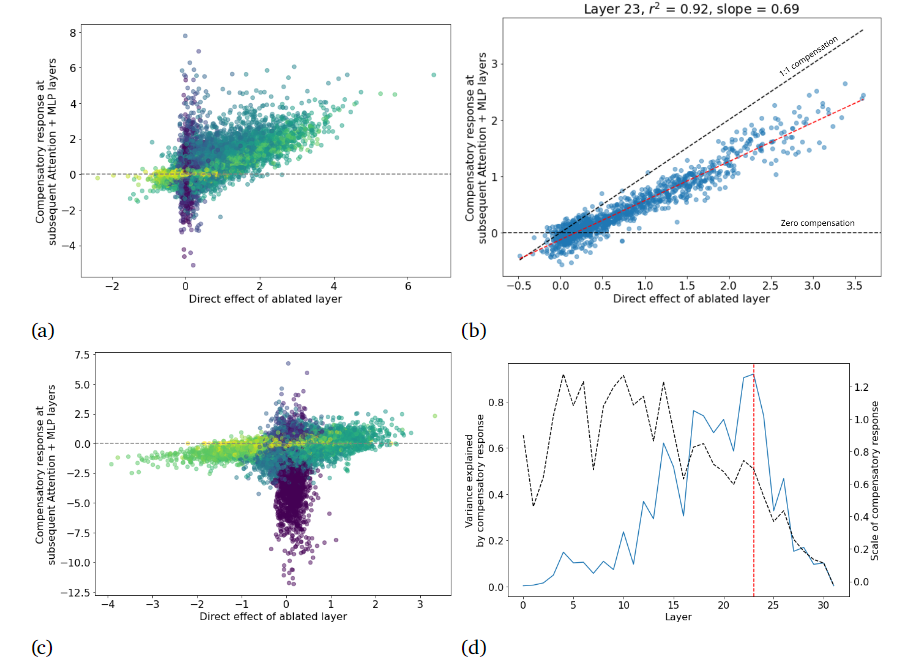  
Figure 7 | Results from carrying out ablations at all layers across the entire Counterfact dataset. (a)
Direct effects against compensatory effect for attention layers, with colourmap indicated network
depth. Middle layers show strong correlations whereas early and late layers do not. (b) Relation
between direct and compensatory effect at the layer with the highest correlation, which occurs at
layer 23 where compensation explains 92% of the variance in changes between the intact and ablated
network. (c) Same as (a) but for MLP layers. (d) Summary of variance explained (solid blue line)
and slope (dashed black line) of a linear regression between direct and compensatory effects at each
attention layer. Red line marks layer shown in subfigure (c).

## 4.2 Results
*We will see if the results replicate and match up on this version of Pythia!*

### 4.2.0 Official Results (Figure 7)

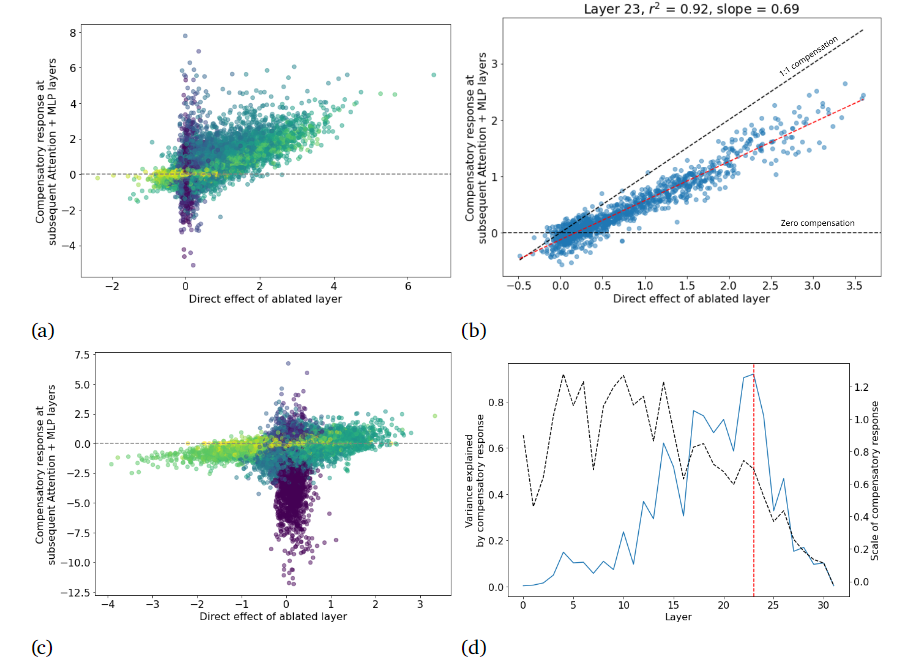  
Figure 7 | Results from carrying out ablations at all layers across the entire Counterfact dataset. (a)
Direct effects against compensatory effect for attention layers, with colourmap indicated network
depth. Middle layers show strong correlations whereas early and late layers do not. (b) Relation
between direct and compensatory effect at the layer with the highest correlation, which occurs at
layer 23 where compensation explains 92% of the variance in changes between the intact and ablated
network. (c) Same as (a) but for MLP layers. (d) Summary of variance explained (solid blue line)
and slope (dashed black line) of a linear regression between direct and compensatory effects at each
attention layer. Red line marks layer shown in subfigure (c).

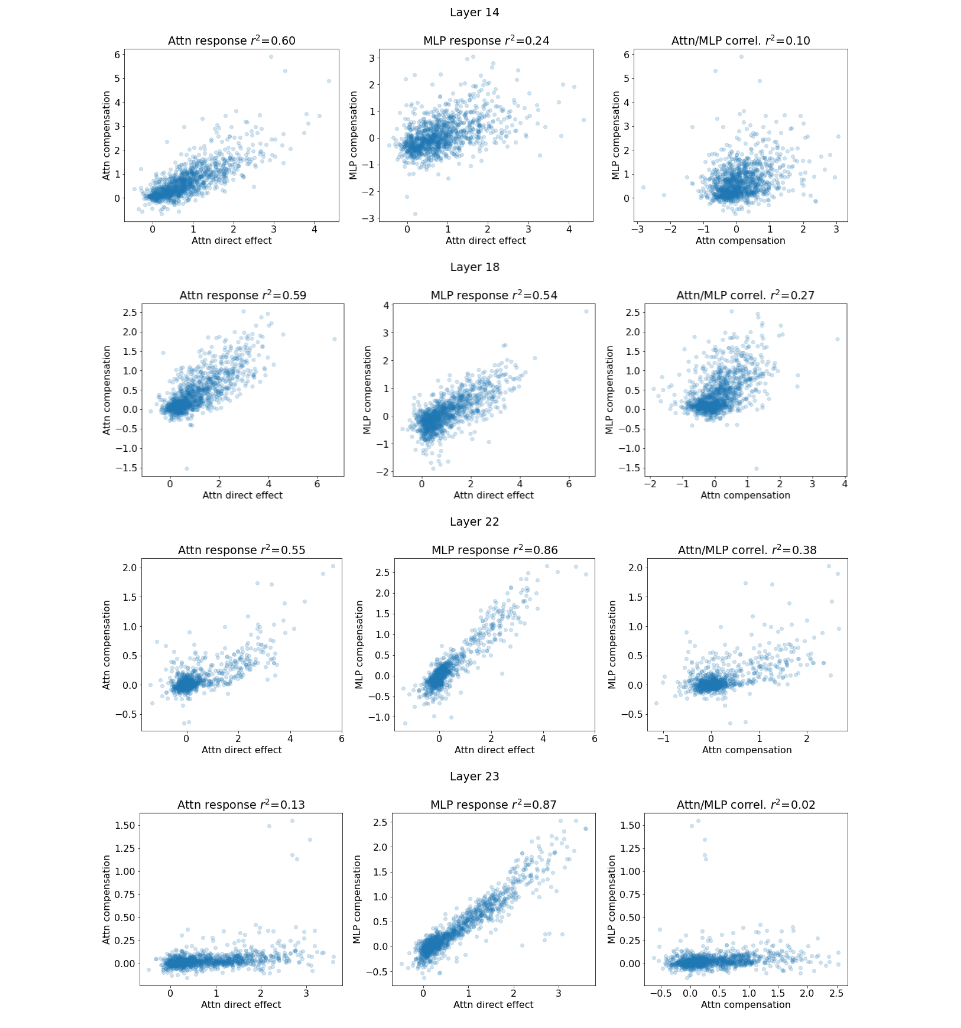  
Figure 8 | Per-layer compensation results for a selection of ablation layers. The balance between the
effect due to the attention and MLP layers shifts from attention to MLP as depth increases.

Results from full quantification of the compensatory effects across the full Counterfact dataset are shown in Figure 7, with data further broken out to individual layers in Figure 8. We highlight the following observations from these results:

In [ ]:
# Compare correlations of direct and compensatory effects across layers

# just define the method here, don't run it

**Direct and compensatory effects are only well-correlated at intermediate layers:**   
early layer ablations have large total effects but almost no direct effect (Figure 8a,c, c.f. Figure 2) whereas very late layers only have non-negligible direct effect (which makes sense as there are few downstream layers for them to have an effect on).

In [ ]:
# Code compensatory effect & direct effect across layers. 
# Do we get the same conclusions? Are there any discernable patterns in the smaller pythia models?

# just define the method here, don't run it

**The compensatory response is almost entirely responsible for changes in direct effect at later layers.**
Compensatory response is very highly correlated at intermediate-late layers (see Figure 8b,
d), suggesting that the network’s response to ablations at these layers is almost entirely driven by the
Hydra effect and a decrease in MLP erasure. Layer 23 (of 32) marks the high point of this phenomenon,
with 92% of the variance in Δ𝐷𝐸 in downstream layers being explained by the Hydra effect.

In [ ]:
# Do the linear regression. What does it mean? I don't really understand the purpose of this plot.

# just define the method here, don't run it

**The compensatory response does not fully restore the output:**
fitting a linear regression between
direct effect and compensatory response gives a slope of less than one at all layers past layer 13
(see Figure 7). This implies that these ablations do have a nonzero total effect, but one that is much
smaller than it would have been without the Hydra effect and responses from erasure MLPs.

In [ ]:
# Plot delta_direct_effect for attention and MLP layers. There will be a plot for each layer chosen for ablation, since we're measuring its downstream effects
# What was the measure again for whether hydra effect is occuring vs MLP erasure?

# just define the method here, don't run it

**The balance between the Hydra effect and reduction in MLP erasure shifts with network depth**
Figure 8 shows Δ𝐷𝐸 for attention and MLP layers separately at different layers in the network. In
early layers changes in attention direct effect play a considerably larger role, whereas by layer 22 the
balance has shifted such that the the MLP response is considerably more predictive and at layer 23
almost all of the response is occuring in the erasure MLPs.

### Our results

In [ ]:
# run the methods defined above

When we do them

# 5. Related Work

The use of techniques from causal inference to analyse neural networks has been used in a range
of cases, including the causal tracing method for locating factual knowledge (Meng et al., 2022),
mediation analyses for gender bias (Vig et al., 2020a,b) and analysis of syntactic agreement (Finlayson
et al., 2021). There is also a recent line of work on constructing causal abstractions of neural network
computations (Geiger et al., 2021, 2022, 2023a,b; Massidda et al., 2022). The use of ablations as a way
of validating hypotheses about mechanisms in neural networks has been previously suggested (Chan
et al., 2022; Leavitt and Morcos, 2020; Morcos et al., 2018), although our findings caution against
straightforwardly interpreting low effectiveness of ablations as meaning that a network component is
unimportant.

Earlier work on residual networks (of which decoder-only transformers are a special case) deter-
mined that for image classification networks, residual networks behave like ensembles of shallower
networks (Veit et al., 2016). This work introduced both the ‘unravelled view’ of residual networks
that we make use of and experimented with ablating network layers at test time, determining that
most effective paths through residual networks are short and layers often do not depend on one another.

The idea of interpreting neural networks in terms of their internal mechanisms or circuits Olah
et al. (2020) (often referred to as mechanistic interpretability) is relatively recent. Earlier work on
vision models (Olah et al., 2018) identified human-understandable neurons and simple circuits (for
instance curve detectors (Cammarata et al., 2020)). Subsequent work on transformers has identified
‘induction circuits’ responsible for simple instances of in-context learning (Elhage et al., 2021; Olsson
et al., 2022), as well as a mechanism for indirect object identification (Wang et al., 2022) and the
mechanism underlying the ‘grokking’ phenomenon (Chughtai et al., 2023; Nanda et al., 2023; Power
et al., 2022).

# 6. Conclusion
- summary of findings
- implications for interp research
- implications of language modelling research
- possible extensions
- there is no code here

**Findings**   
In this work we have investigated the computational structure of language models during
factual recall by performing detailed ablation studies. We found that networks exhibit surprising
self-repair properties: knockout of an attention layer causes another attention layer to increase its
effect in order to compensate. We term this new motif the Hydra effect. We also found that late-layer
MLPs appear to have a negative-feedback/erasure effect: late layer MLPs often act to reduce the
probability of the maximum-likelihood token, and this reduction is attenuated when attention layers
promoting that token are knocked out. We find that these effects are approximately linear, and that
at middle layers (where these effects are strongest) the Hydra effect and reduction in MLP effects
collectively act to restore approximately 70% of the reduction in token logits.

**Implications for interpretability research**  
These findings corroborate earlier work on neural
network computations in GPT-2 Small (Wang et al., 2022) which reported a similar effect that the
authors term ‘backup heads’. The authors of (Wang et al., 2022) hypothesised that dropout (Srivastava
et al., 2014) was responsible for self-repair behaviour, which we disprove as the model we study
(Chinchilla 7B) was trained without any form of dropout or stochastic depth. The occurrence of
this motif across tasks and models suggests that it may be an instance of universality (Olah et al.,
2020). Our original motivation for this work was performing automated ablation studies using an
algorithm similar to (Conmy et al., 2023), which led to us investigating the changes in network
computation under repeated ablations. The Hydra effect poses a challenge to automating ablations:
if we prioritise network components for ablation according to their total effect, we will be using a
measure that does not fully reflect the computational structure of the intact network. Fortunately, the
fact that the compensatory effect is typically less than 100% means that automated ablations will
still have some signal to work with. The Hydra effect and erasure MLPs also have implications for
attributing responsibility for a network’s output to individual network components: is the responsible
component the attention layer that has the effect in the intact network, or the circuits that act to
compensate following ablation? The framework of actual causality (Halpern, 2016) may be a useful
way to approach this question.

Our findings also suggest that attempting to assign semantics to MLP neurons may be more
complicated than otherwise expected: erasure MLPs may have no clear semantics in terms of the
model’s input, as they are responding to the language model’s internal computations. Finally, our
findings also have implications for work that attempts to understand language models by unembedding
the output of individual layers (e.g. (Geva et al., 2022b)) - this corresponds to an assumption that the
direct effect is the only meaningful effect of a layer. The existence of erasure MLPs poses a challenge
to this approach to interpretability: if the output of an attention layer or MLP is guaranteed to be
partially undone by an erasure MLP, it’s no longer straightforward to interpret that output in terms of
its direct effects on logits: the effect of the mediating MLPs should also be considered. Our findings
also provide context for earlier ablation studies (such as (Morcos et al., 2018)): it is not enough
simply to measure the total effect of an ablation without investigating downstream changes in the network, and more important network components are more likely to be robust to ablation.

**Implications for language modelling research**  
From the perspective of language modelling the
Hydra effect is surprising: it confers robustness to a kind of ablation that the model will never
experience at inference time and so appears to be a waste of parameters. If this is the case, what
benefit does it confer? One possibility (drawing on the analytical framework of Tinbergen’s four
questions (Tinbergen, 1963)) is that the Hydra effect confers no benefit at inference time, but is
beneficial in the context of training. If gradient descent were to occasionally break network components
then a kind of ‘natural dropout’ would occur during training. In this case it would be beneficial for
networks to be robust to layers failing. We emphasise that this is conjecture, however, and would
need further research.

**Possible extensions**
Although we have identified two new motifs, we have not investigated more
deeply than individual layers (for instance looking at the level of individual attention heads or
directions in activation space). Achieving a greater level of precision is a natural next step and would
unlock deeper understanding of the mechanisms at play here. Some questions that could be answered
with a finer-grained understanding of how this kind of redundancy operates include:
1. How much does the Hydra effect occur across the entire training distribution? Does sequence
length play any role?
2. What are the Hydra effect attention heads responding to the presence/absence of in the residual
stream?
3. Do the same downstream heads act as Hydra effect replacement heads across multiple contexts?
4. What causes the Hydra effect? Is the natural dropout hypothesis correct or is some other
phenomenon responsible (superposition has been suggested as an alternative explanation).
5. Is there a Hydra effect for features rather than direct effect on logits?
6. What are the erasure heads responding to in the residual stream? Do they have a ‘recalibration’
effect when a wider range of tokens is considered?
7. If we account for redundancy/Hydra effect, can we probe network structure by using targeted
ablations?